## OCNT-DMSLIB-1 DMS Assay Run #4: TYK2 Inhibitors

| ID | Condition | Concentration (M) | Replicates
| --- | ----------- | --- | ----------- |
| 1 | None | 0 | 4 |
| 2 | BMS-986202 + IFN-alpha (100U/mL) | 3.6e-9 | 4 |
| 3 | BMS-986202 + IFN-alpha (100U/mL) | 2e-8 | 4 |
| 4 | BMS-986202 + IFN-alpha (100U/mL) | 1e-6 | 4 |
| 5 | Zasocitinib + IFN-alpha (100U/mL) | 1e-6 | 4 |
| 6 | Ropsacitinib + IFN-alpha (100U/mL) | 1e-7 | 4 |

We have three inhibitors at either one or three concentrations each, plus an untreated control condition. This report generates similar results to the initial full length TYK2 assay, focused on identifying drug resistance (i.e. GoF) effects.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Drug Resistance/Gain-of-Function](#part4)

In [2]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2),
               drug = drug.x,
               conc = conc.x) %>%
        select(drug, conc, pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [7]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run4/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "condition", "condition_conc","clone"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

Rows: 14118391 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): sample, barcode, lib, chunk, wt_aa, mut_aa, wt_codon, mut_codon, c...
dbl  (4): count, pos, dox, condition_conc

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


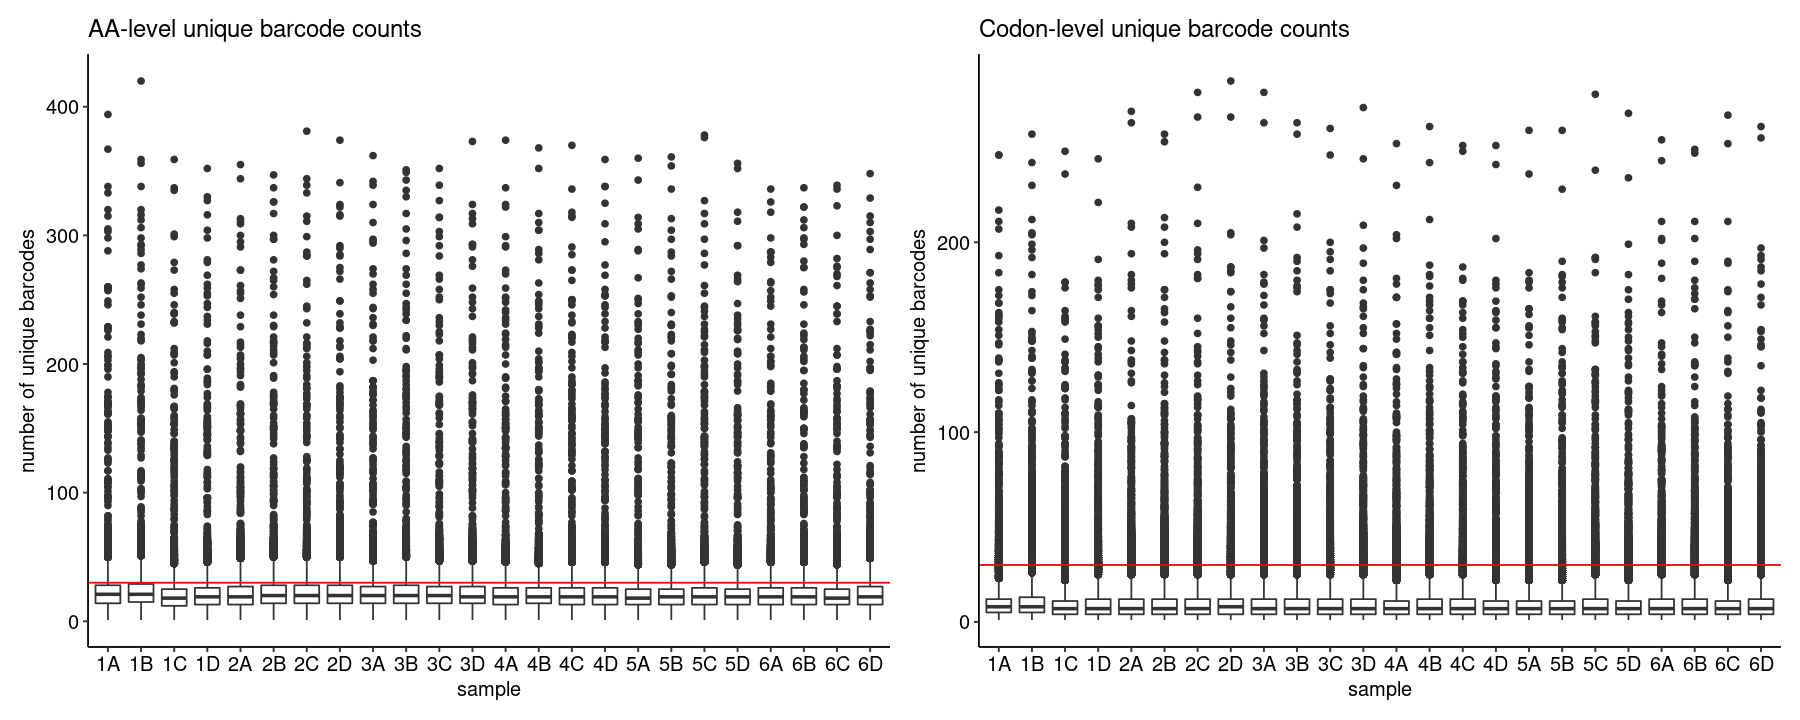

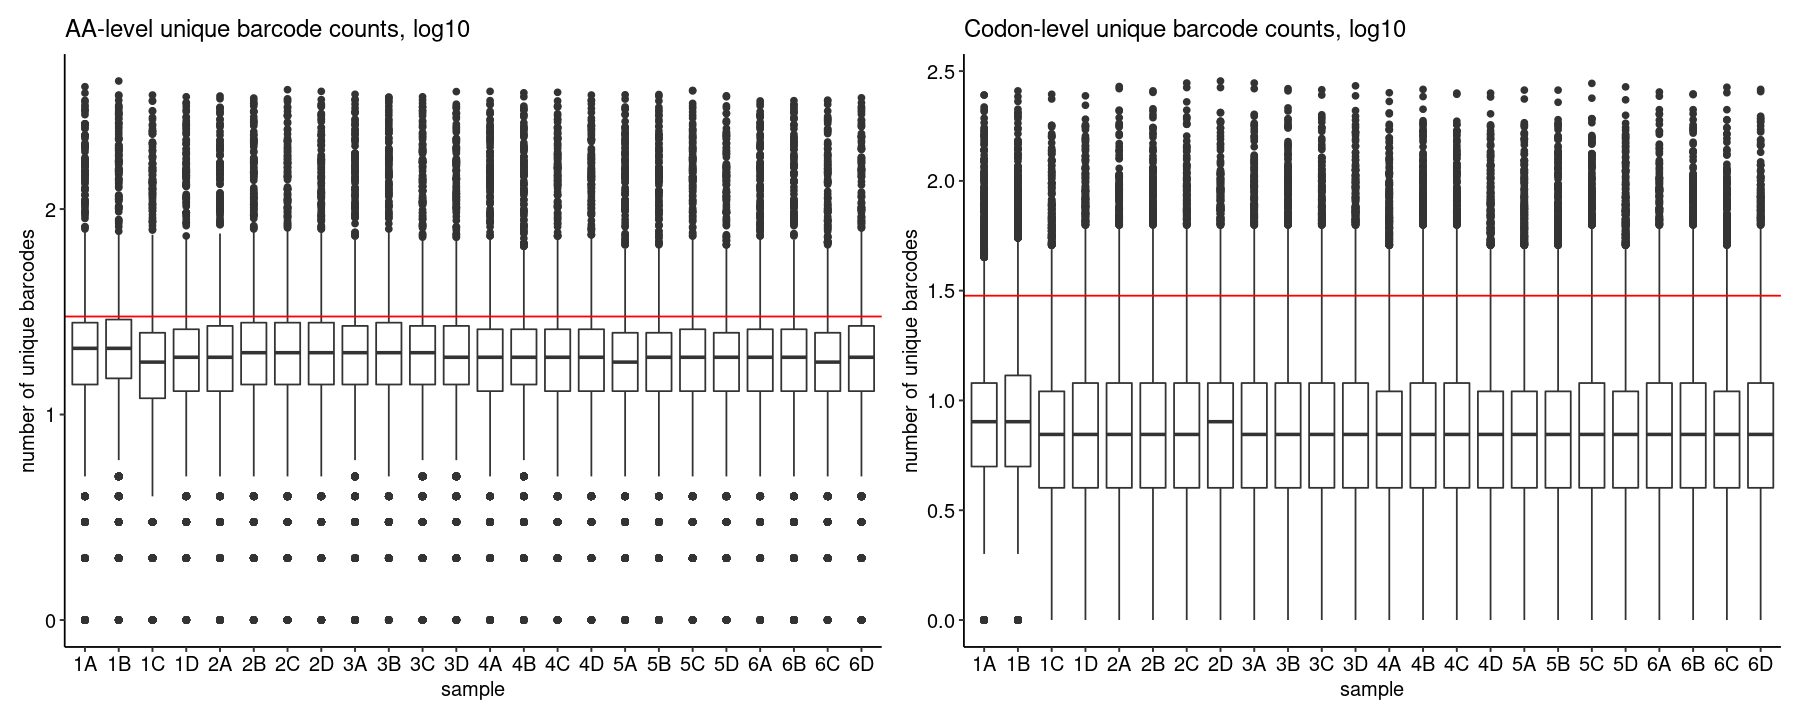

In [8]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using sample `1A` only; the remaining plots can be found [here](./coverage-plots):

In [10]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-1-assay-run4-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

In [11]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_

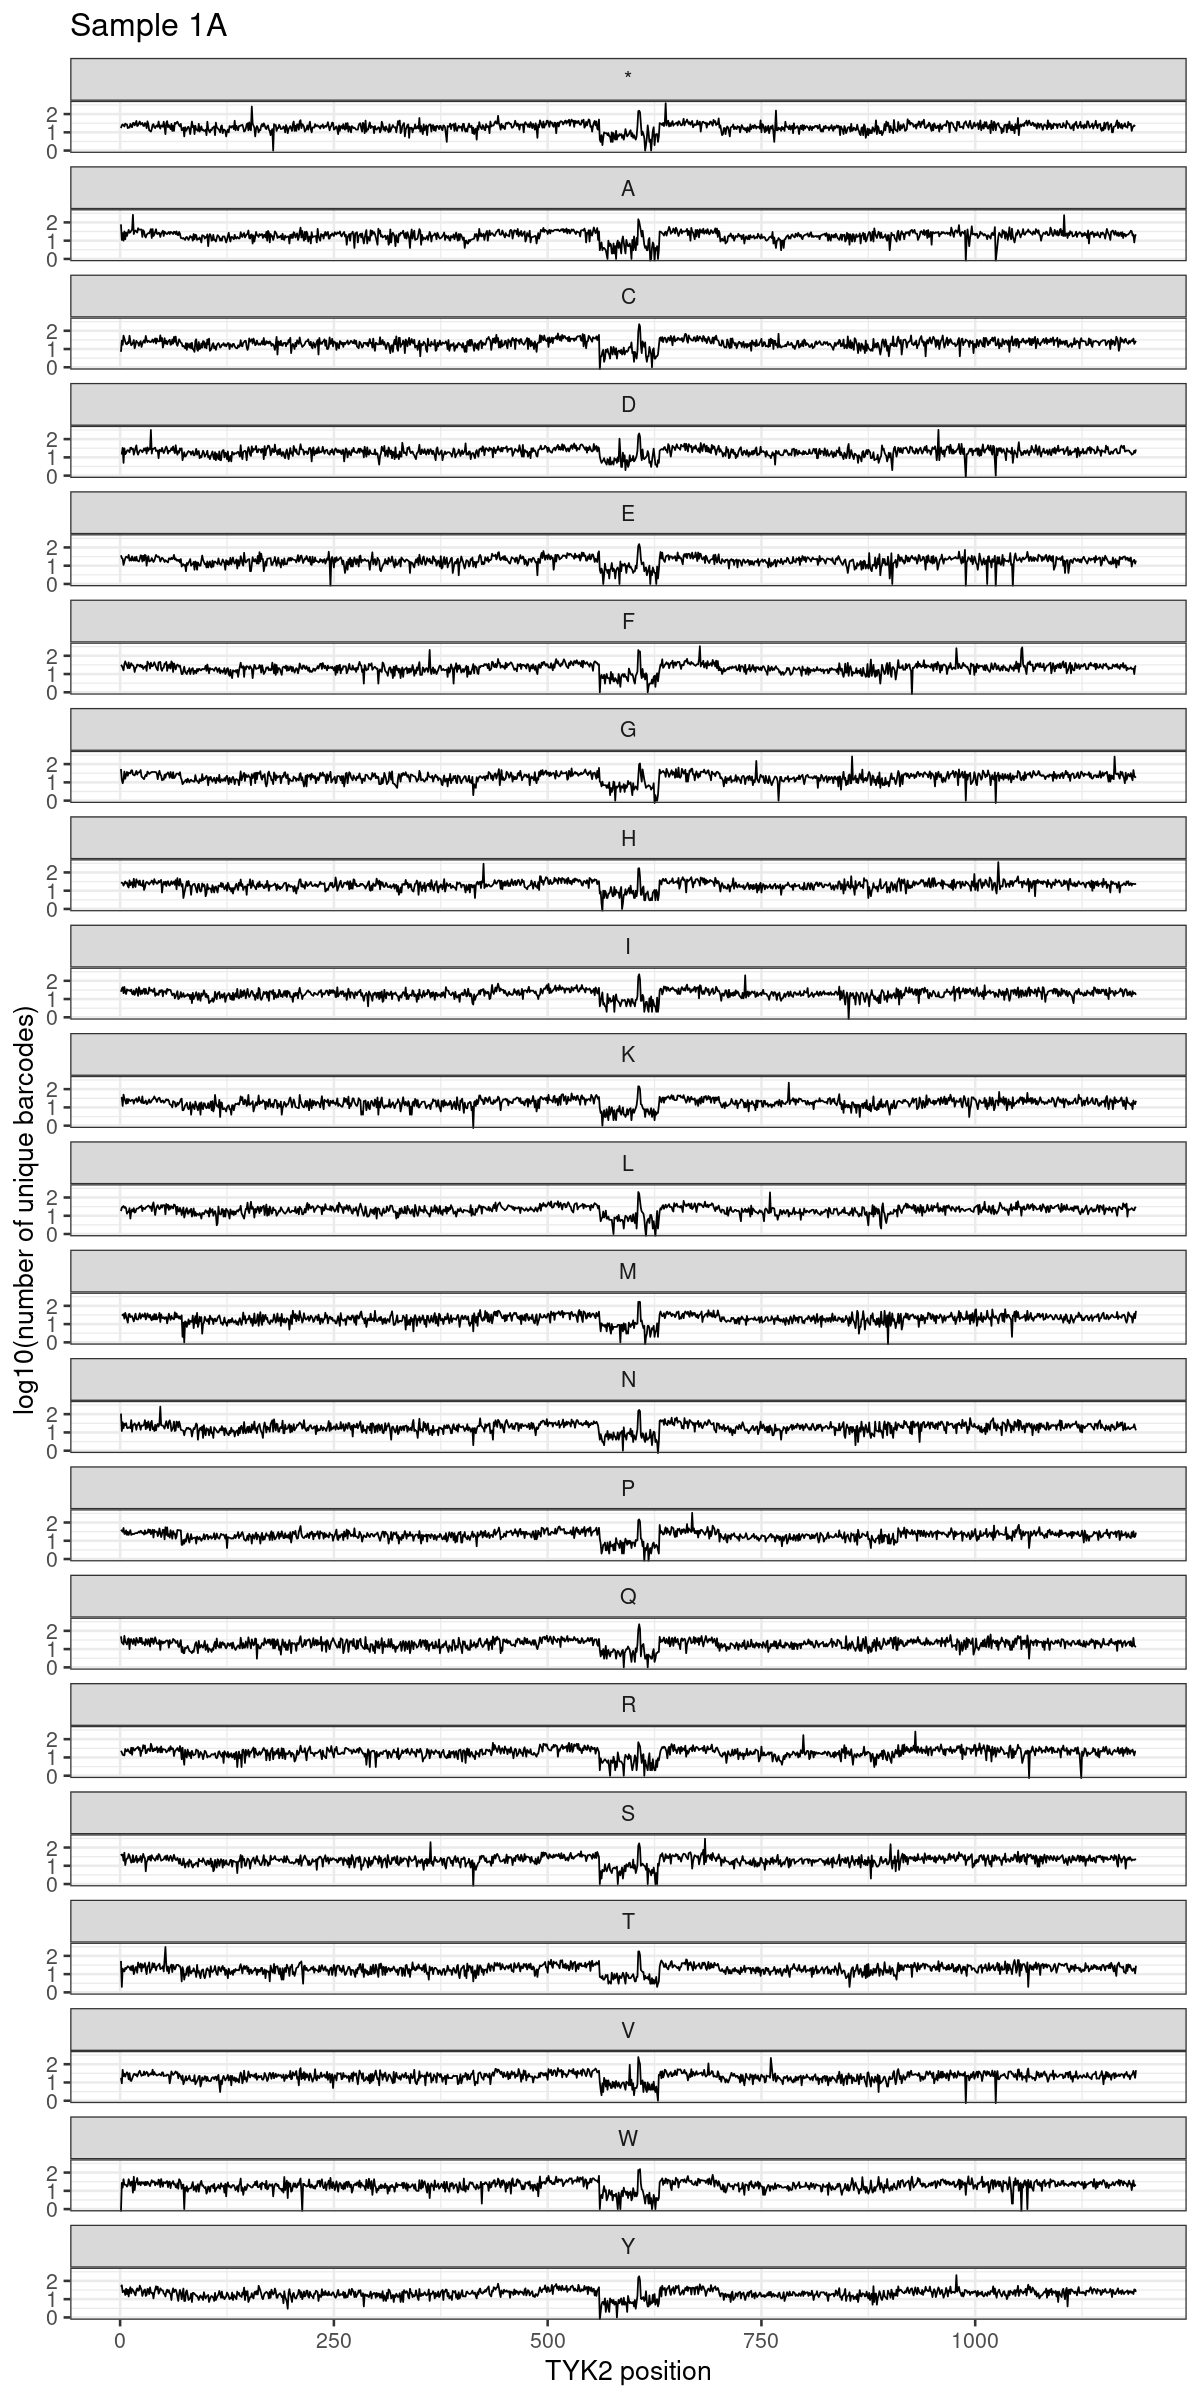

In [12]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

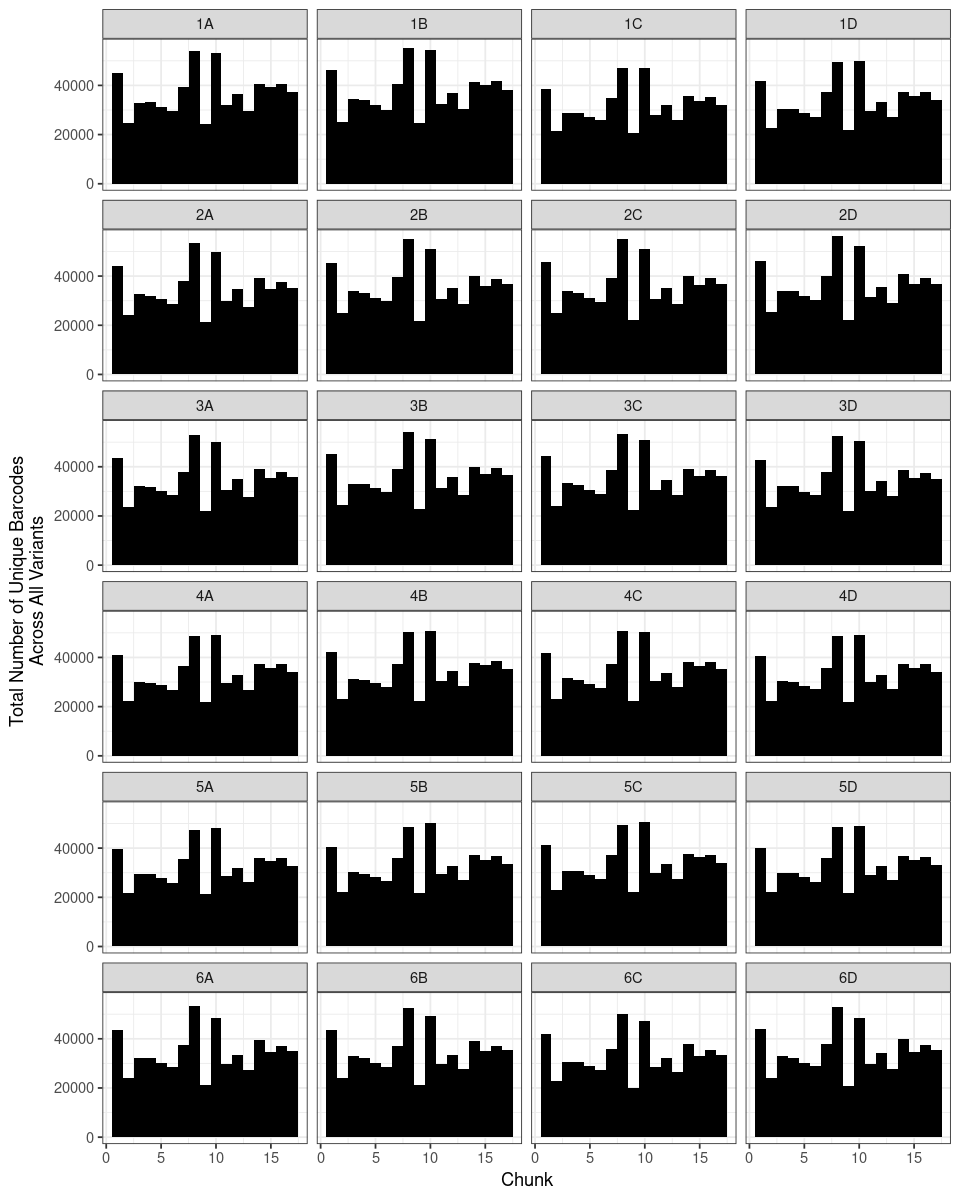

In [9]:
options(repr.plot.width = 8, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = if_else(chunk == "12rc", "12", chunk),
           chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

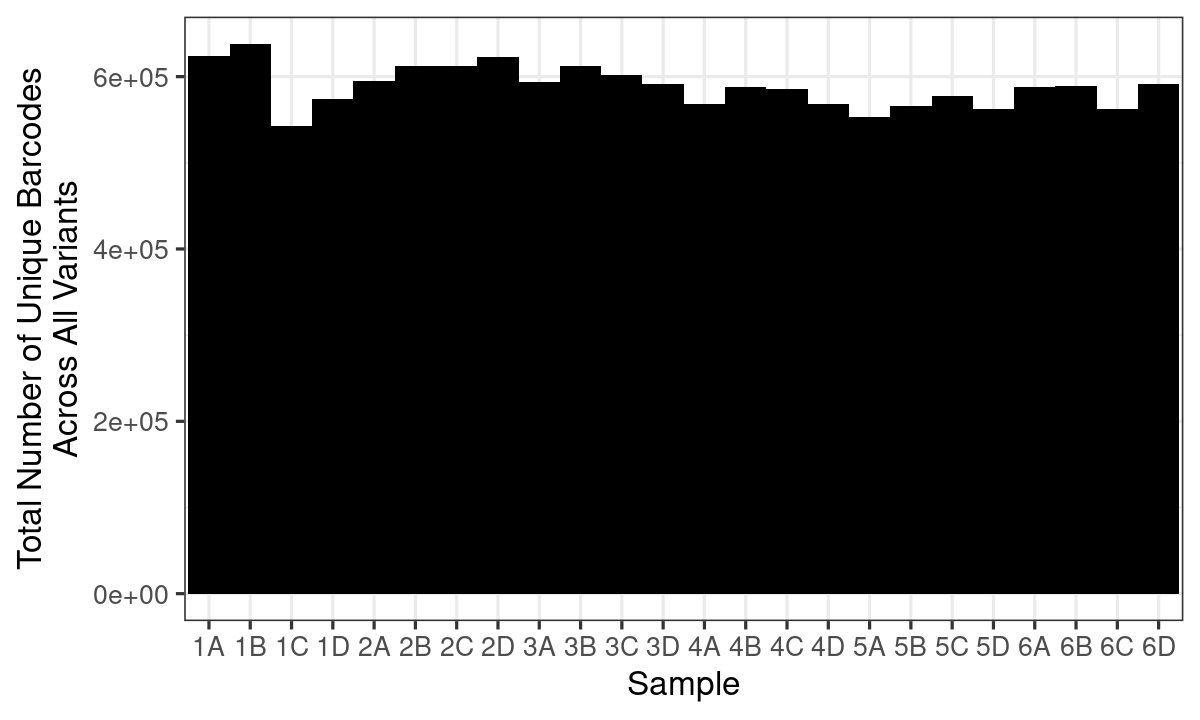

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

In [3]:
sumstats <- dir_ls(path = "../sumstats/TYK2/run4/", regexp = "tyk2-.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           condition = gsub("BMS-986202","BMS-986202_", condition),
           condition = gsub("nib", "nib_", condition),
           condition = gsub("None0", "None_0", condition),
           conc = as.numeric(gsub(".*_","",condition)),
           drug = gsub("_.*","",condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    select(-group) %>%
    write_tsv("../sumstats/TYK2/run4/tyk2-assay4-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

In [5]:
conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None_0")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None_0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("IFNalpha+BMS-986202_1e-06 - None_0",
                                         "IFNalpha+BMS-986202_2e-08 - None_0",
                                         "IFNalpha+BMS-986202_3.6e-09 - None_0",
                                         "IFNalpha+Ropsacitinib_1e-07 - None_0",
                                         "IFNalpha+Zasocitinib_1e-06 - None_0")))

sumstats_all <- sumstats_none_contr %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_drug_zaso <- compute_difference(test = "IFNalpha+Zasocitinib_1e-06",
                                    control = "IFNalpha+BMS-986202_1e-06",
                                    sumstats = sumstats)  %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_drug_rops <- compute_difference(test = "IFNalpha+Ropsacitinib_1e-07",
                                    control = "IFNalpha+BMS-986202_3.6e-09",
                                    sumstats = sumstats)  %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_all %>% write_tsv("../sumstats/TYK2/run4/tyk2-assay4.tsv")
sumstats_drug_rops %>% write_tsv("../sumstats/TYK2/run4/tyk2-assay4-drugCompare-rops.tsv")
sumstats_drug_zaso %>% write_tsv("../sumstats/TYK2/run4/tyk2-assay4-drugCompare-zosa.tsv")

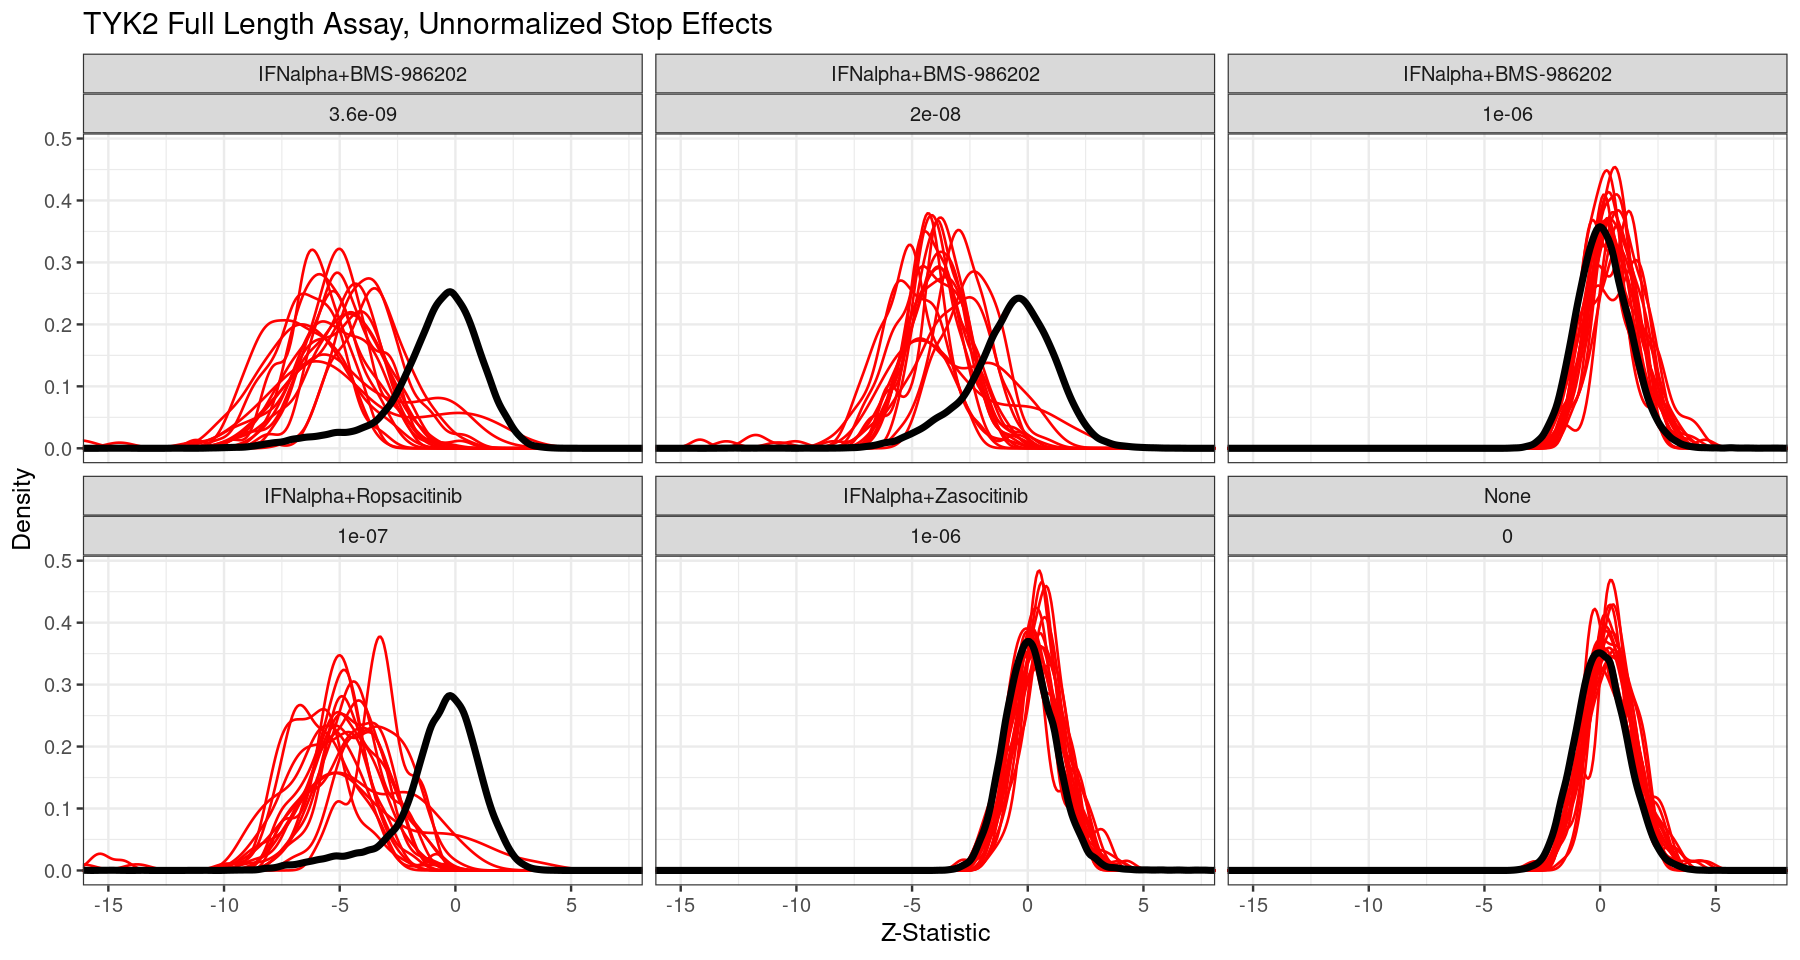

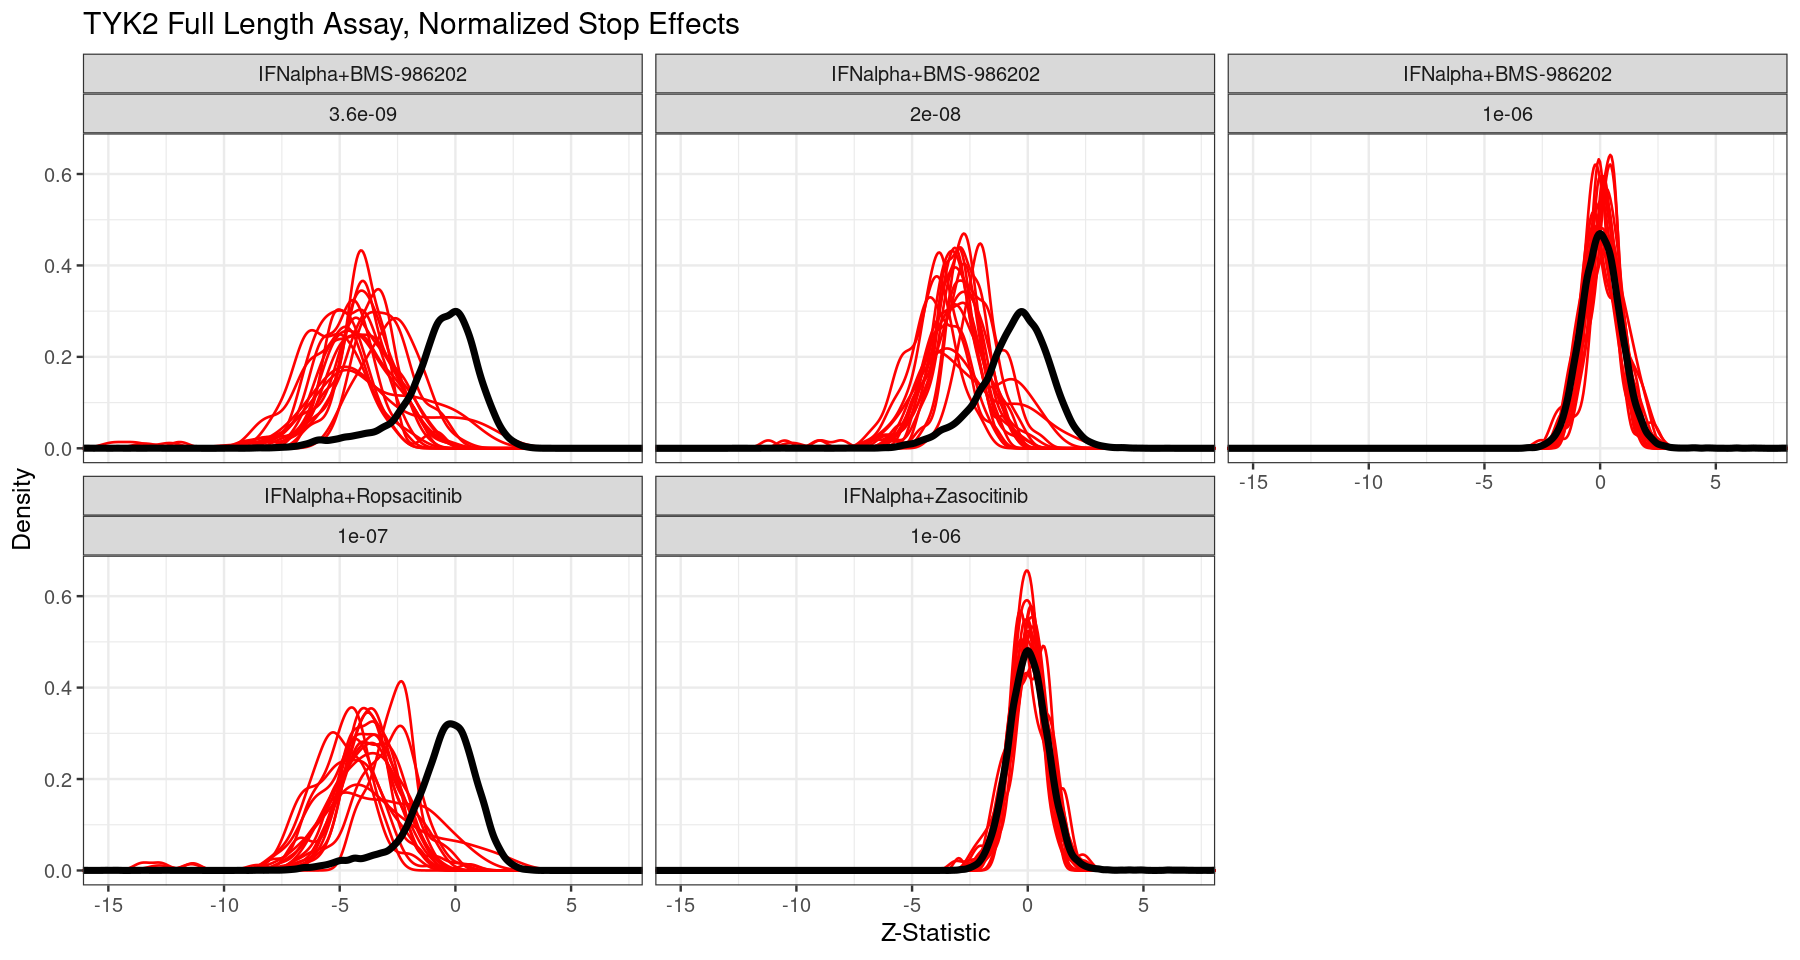

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8)
sumstats %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>% 
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~drug + conc, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Unnormalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

sumstats_all %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~drug + conc, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Normalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [7]:
sumstats_all %>%
    count(drug,
          conc,
          direction = if_else(estimate > 0, "GoF", "LoF"),
          sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n, values_fill = 0) %>%
    arrange(drug, conc) %>%
    kable(type = "markdown", digits = 10)



|drug                  |    conc|direction | Non-Significant| Significant (FDR < 0.01)|
|:---------------------|-------:|:---------|---------------:|------------------------:|
|IFNalpha+BMS-986202   | 3.6e-09|GoF       |            8398|                        3|
|IFNalpha+BMS-986202   | 3.6e-09|LoF       |           12775|                     2544|
|IFNalpha+BMS-986202   | 2.0e-08|GoF       |            8354|                       38|
|IFNalpha+BMS-986202   | 2.0e-08|LoF       |           13819|                     1509|
|IFNalpha+BMS-986202   | 1.0e-06|GoF       |           12280|                       39|
|IFNalpha+BMS-986202   | 1.0e-06|LoF       |           11401|                        0|
|IFNalpha+Ropsacitinib | 1.0e-07|GoF       |            8660|                        1|
|IFNalpha+Ropsacitinib | 1.0e-07|LoF       |           12907|                     2152|
|IFNalpha+Zasocitinib  | 1.0e-06|GoF       |           12093|                       58|
|IFNalpha+Zasocitinib  | 1.0e-

### Visualizations <a name="part3"></a>

In [3]:
sumstats <- read_tsv("../sumstats/TYK2/run4/tyk2-assay4-unnormalized.tsv")
sumstats_all <- read_tsv("../sumstats/TYK2/run4/tyk2-assay4.tsv")

Rows: 142320 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): clone, chunk, condition, aa, version, drug
dbl (8): pos, estimate, std.error, statistic, p.value, dispersion, conc, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 118600 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
bms_vs_zaso <- compute_difference(test = "IFNalpha+BMS-986202_1e-06",
                                  control = "IFNalpha+Zasocitinib_1e-06",
                                  sumstats) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

bms_vs_zaso_sig <- bms_vs_zaso %>% filter(p.adj < 0.01) %>% select(pos, aa) %>% distinct()

In [23]:
colors <- c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "black")

scatter_data <- sumstats_all %>%
    filter(condition %in% c("IFNalpha+BMS-986202_1e-06 - None_0", "IFNalpha+Zasocitinib_1e-06 - None_0")) %>%
    select(pos, drug, aa, statistic, p.adj) %>%
    pivot_wider(names_from = drug, values_from = c(statistic, p.adj)) %>%
    mutate(`FDR < 0.01` = case_when(`p.adj_IFNalpha+BMS-986202` < 0.01 & `p.adj_IFNalpha+Zasocitinib` < 0.01 ~ "Both",
                           `p.adj_IFNalpha+BMS-986202` < 0.01 & `p.adj_IFNalpha+Zasocitinib` > 0.01 ~ "BMS-986202",
                           `p.adj_IFNalpha+BMS-986202` > 0.01 & `p.adj_IFNalpha+Zasocitinib` < 0.01 ~ "Zasocitinib",
                           TRUE ~ "Neither"),
          `FDR < 0.01` = if_else(`statistic_IFNalpha+Zasocitinib` < 0 & `statistic_IFNalpha+BMS-986202` < 0,
                                 "Neither",
                                 `FDR < 0.01`))

mut_compare_plot <- ggplot() +
    geom_point(data = scatter_data %>% filter(`FDR < 0.01` == "Neither" ),
              aes(x = `statistic_IFNalpha+BMS-986202`,
                  y = `statistic_IFNalpha+Zasocitinib`,
                  color = `FDR < 0.01`)) +
    geom_point(data = scatter_data %>% filter(`FDR < 0.01` != "Neither"),
              aes(x = `statistic_IFNalpha+BMS-986202`,
                  y = `statistic_IFNalpha+Zasocitinib`,
                  #label = paste0(pos, aa),
                  color = `FDR < 0.01`), size = 5) +
    theme_pubr(base_size = 16) +
    ggtitle("Assay 4 Resistance: [IFNa + Inhibitor] Minus [Untreated]") +
    scale_color_manual(values = colors) +
    theme(legend.title = element_blank()) +
    xlab("Z-Statistic, [IFN-alpha + BMS-986202] - [None]") +
    ylab("Z-Statistic, [IFN-alpha + Zasocitinib] - [None]")

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay4-DrugResistCompare-NoVarLabel.pdf",
       mut_compare_plot,
       width = 10, height = 10)

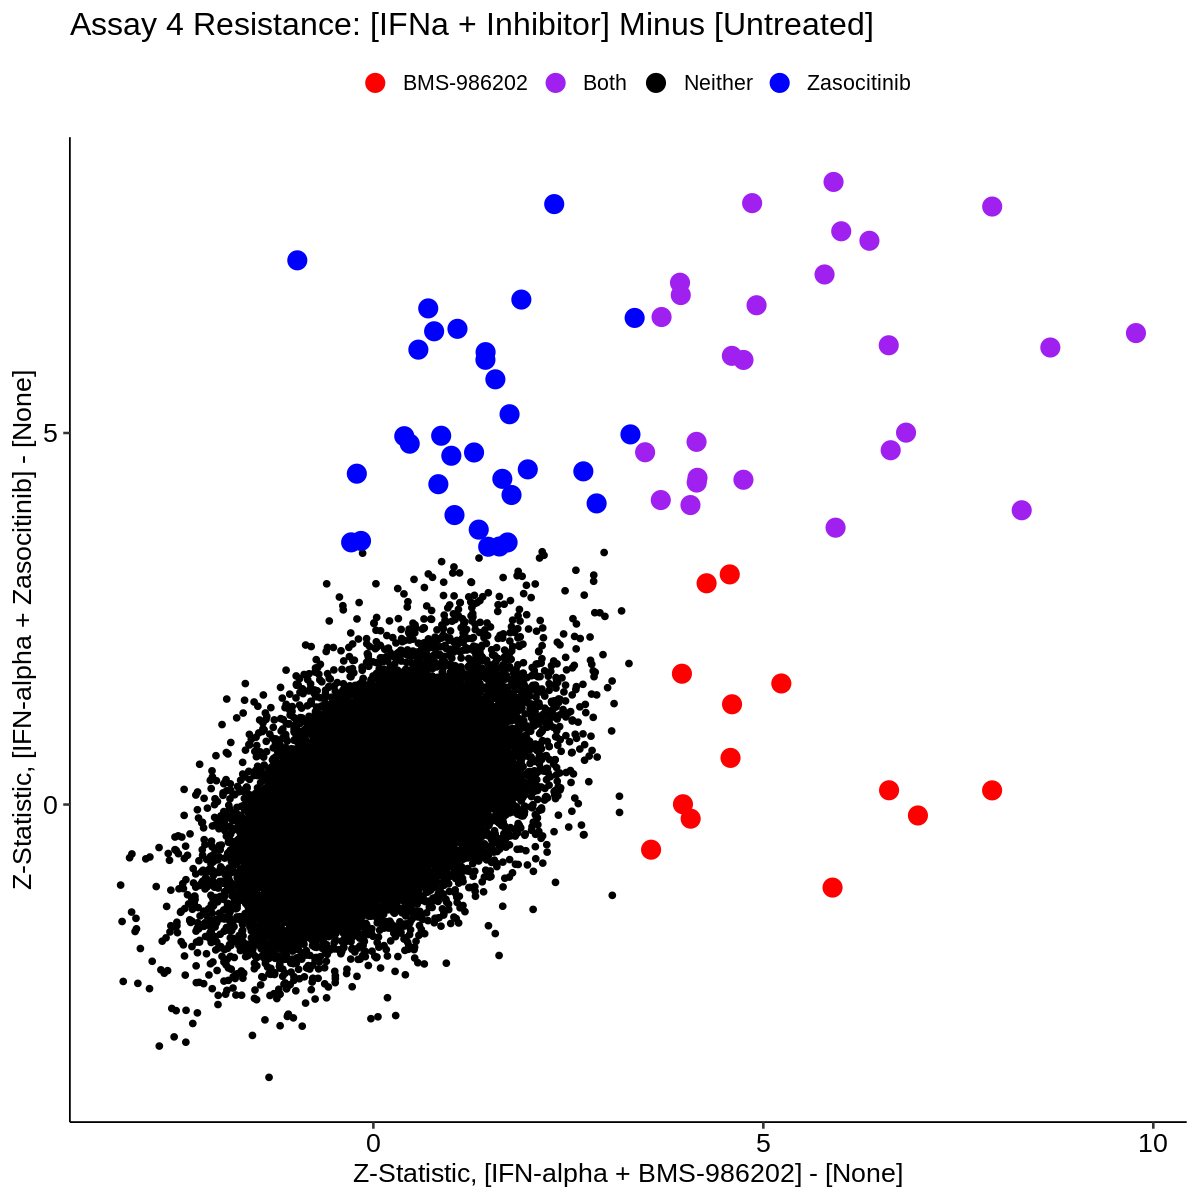

In [24]:
options(repr.plot.width = 10, repr.plot.height = 10)
mut_compare_plot

In [136]:
sig_pos <- scatter_data %>% filter(`FDR < 0.01` != "Neither") %>% pull(pos) %>% unique()

color_grid_all <- scatter_data %>%
    filter(pos %in% sig_pos, aa != "*") %>%
    mutate(aa = factor(aa, levels = c("N","Q","F","W","Y","L","I","V","M","D","E","C","S","T","R","H","K","P","A","G"))) %>%
    ggplot() +
        geom_tile(aes(x = as.factor(pos), y = aa, fill = `FDR < 0.01`)) +
        theme_pubr(base_size = 20) +
        xlab("Residue") + ylab("Amino Acid") +
        ggtitle("Normalized to Untreated") +
        scale_fill_manual(values = c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "lightgray"))

pdf("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay4-DrugResistGrid.pdf", height = 9, width = 13)
color_grid_all + scale_fill_manual(values = c("Both" = "blue", "Zasocitinib" = "blue",
            "BMS-986202" = "lightgray", "Neither" = "lightgray"))
color_grid_all + scale_fill_manual(values = c("Both" = "red", "Zasocitinib" = "lightgray",
            "BMS-986202" = "red", "Neither" = "lightgray"))
color_grid_all + scale_fill_manual(values = c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "lightgray"))
dev.off()

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

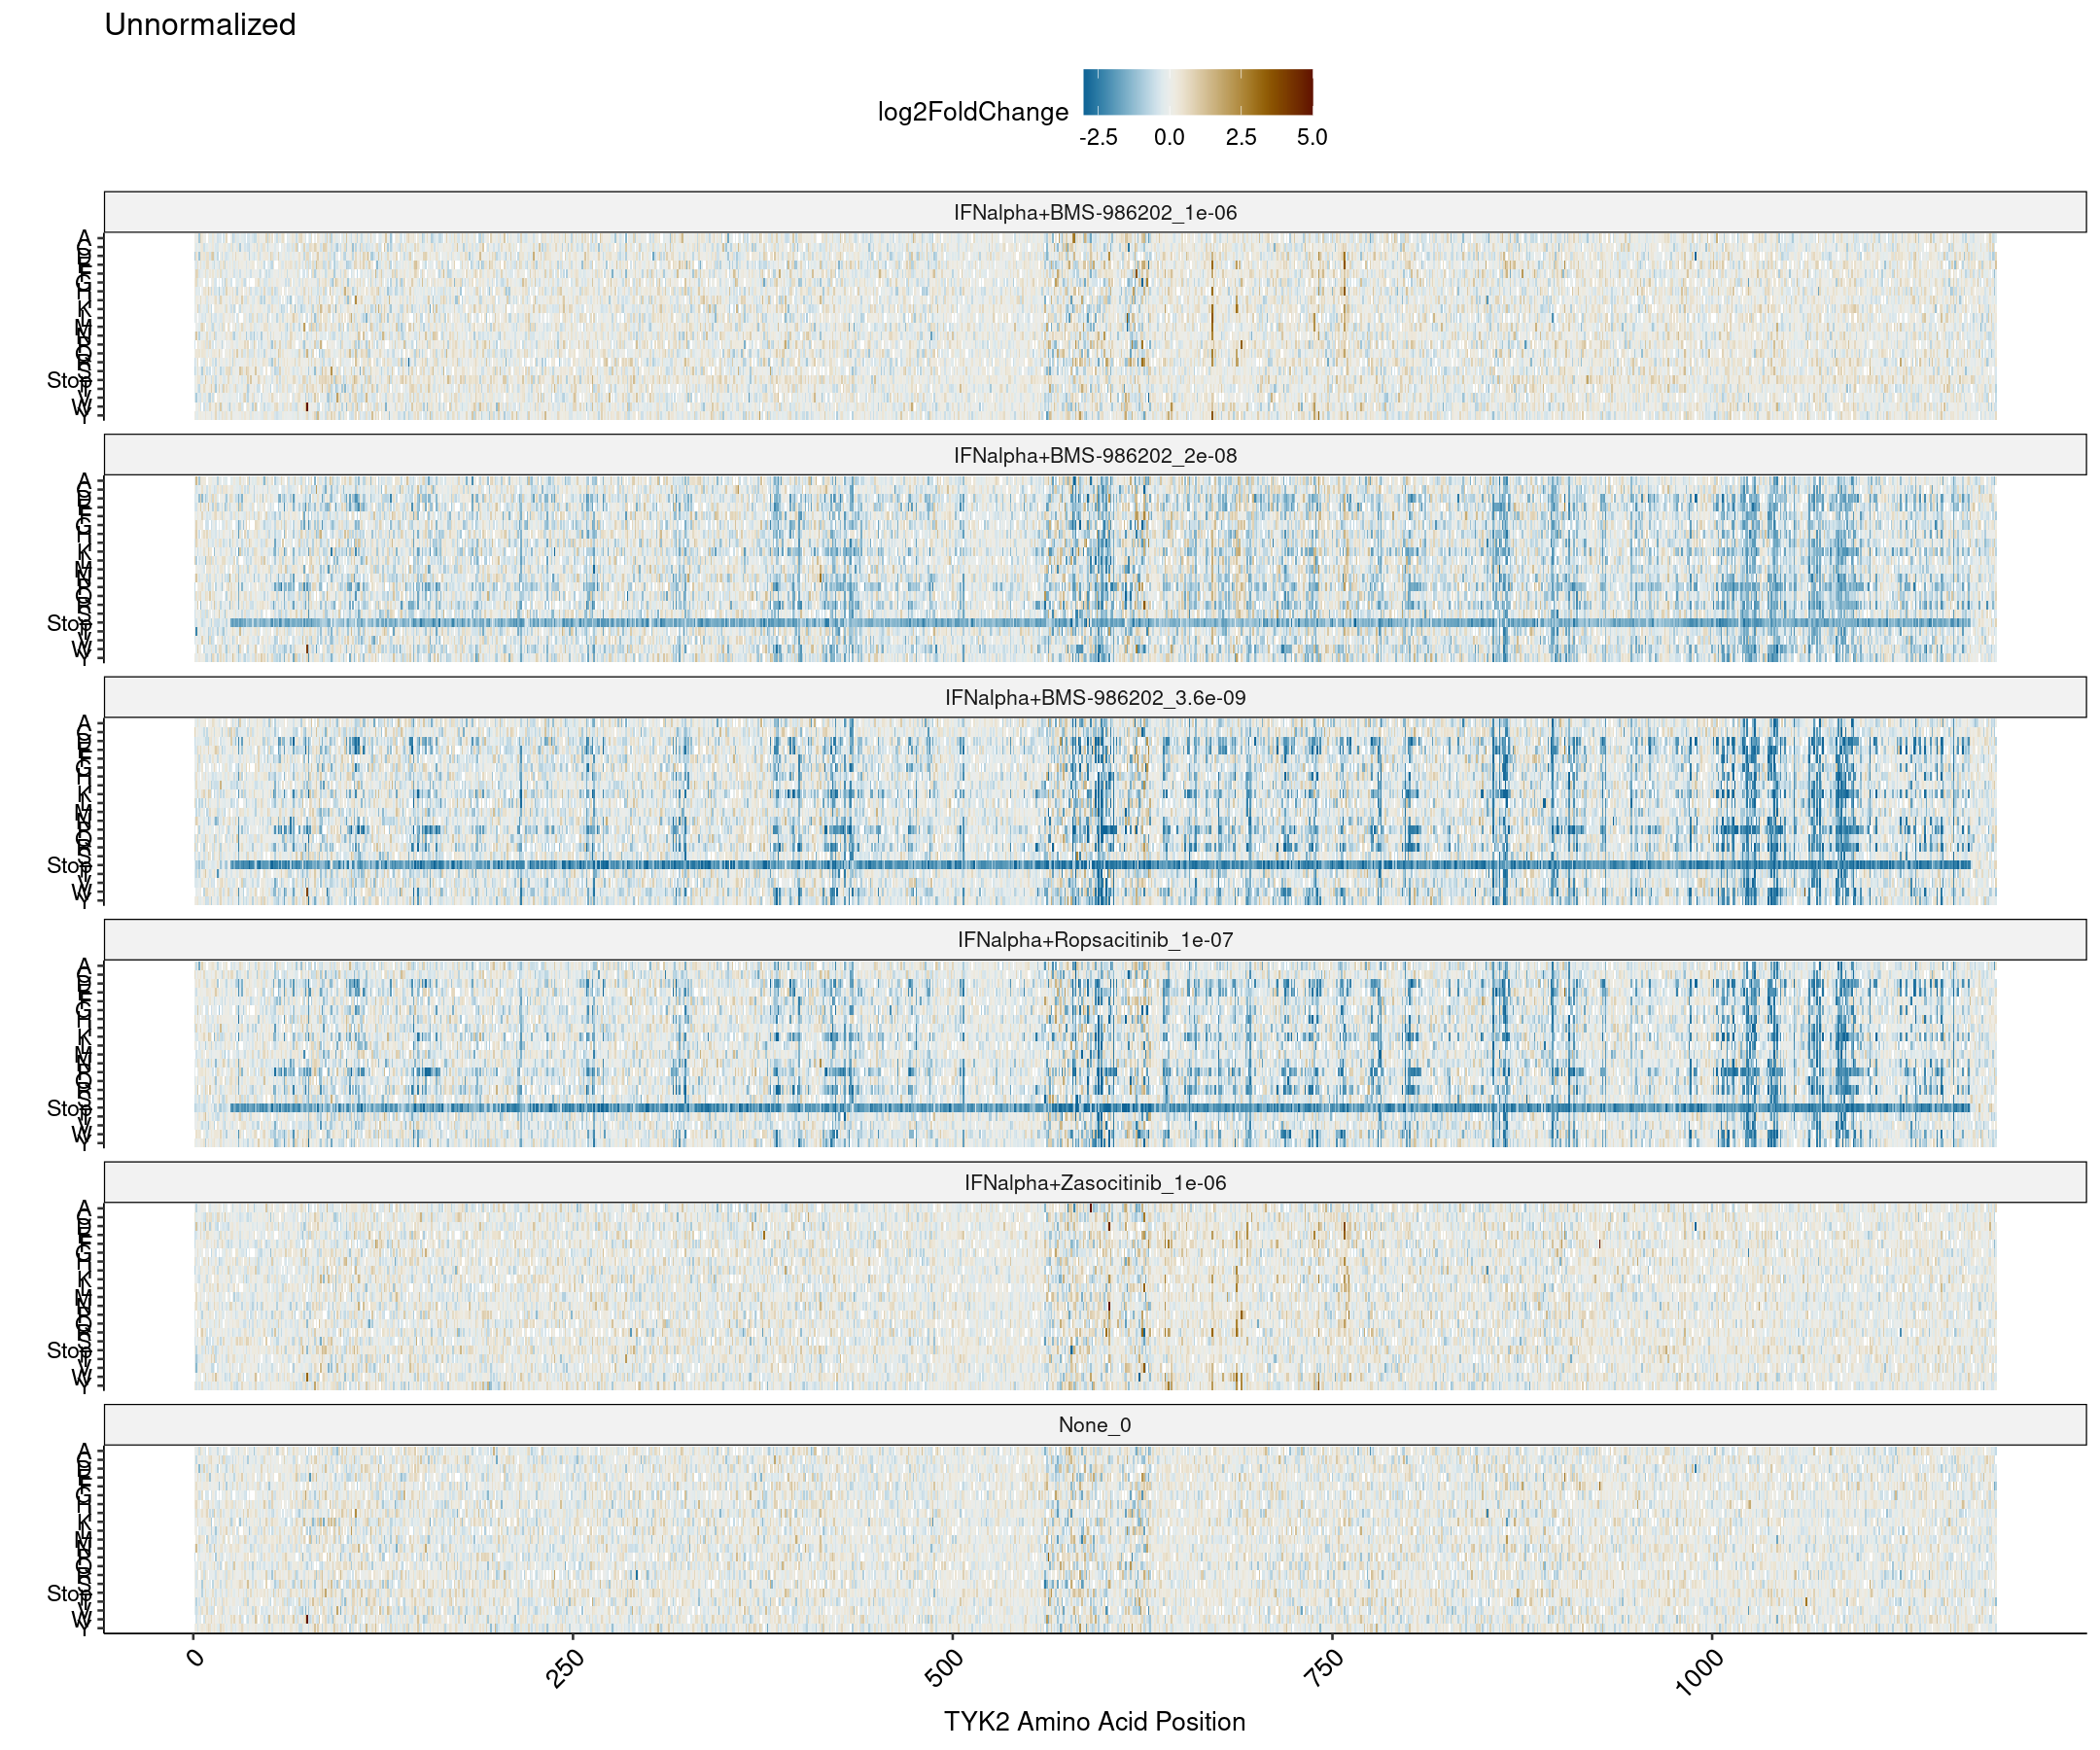

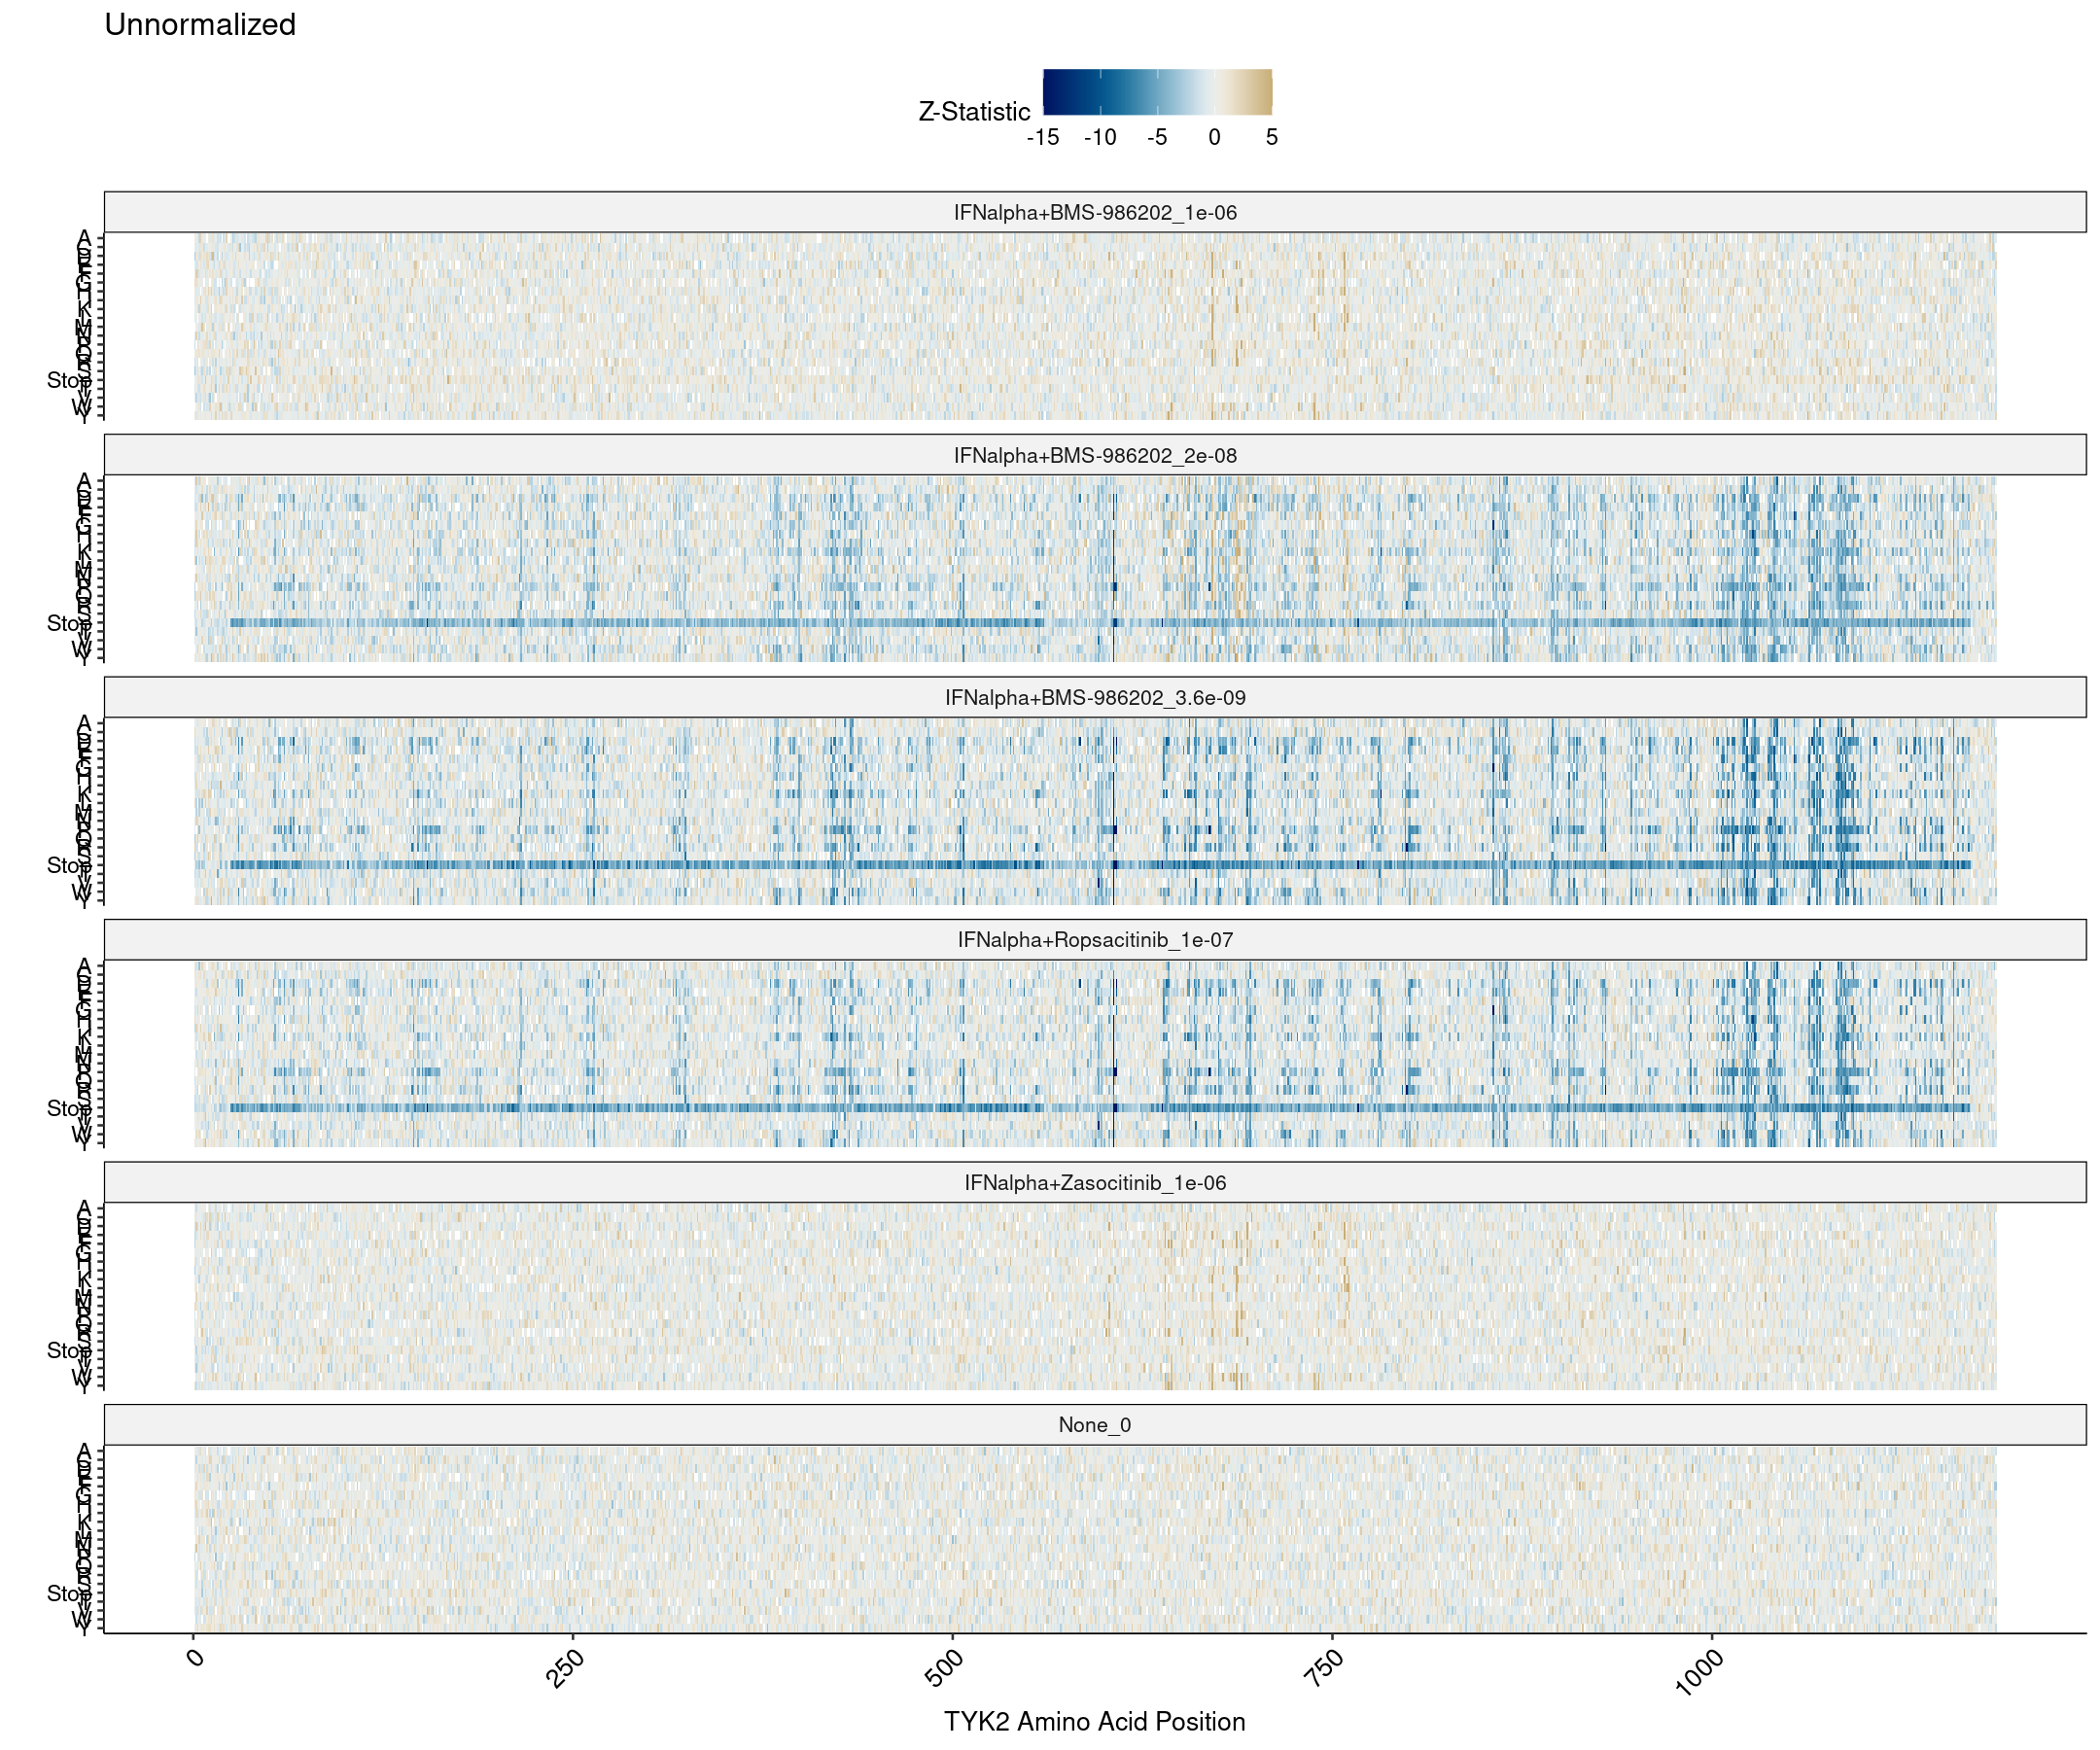

In [8]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa),
           log2FoldChange = estimate/log(2)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa),
           log2FoldChange = estimate/log(2)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

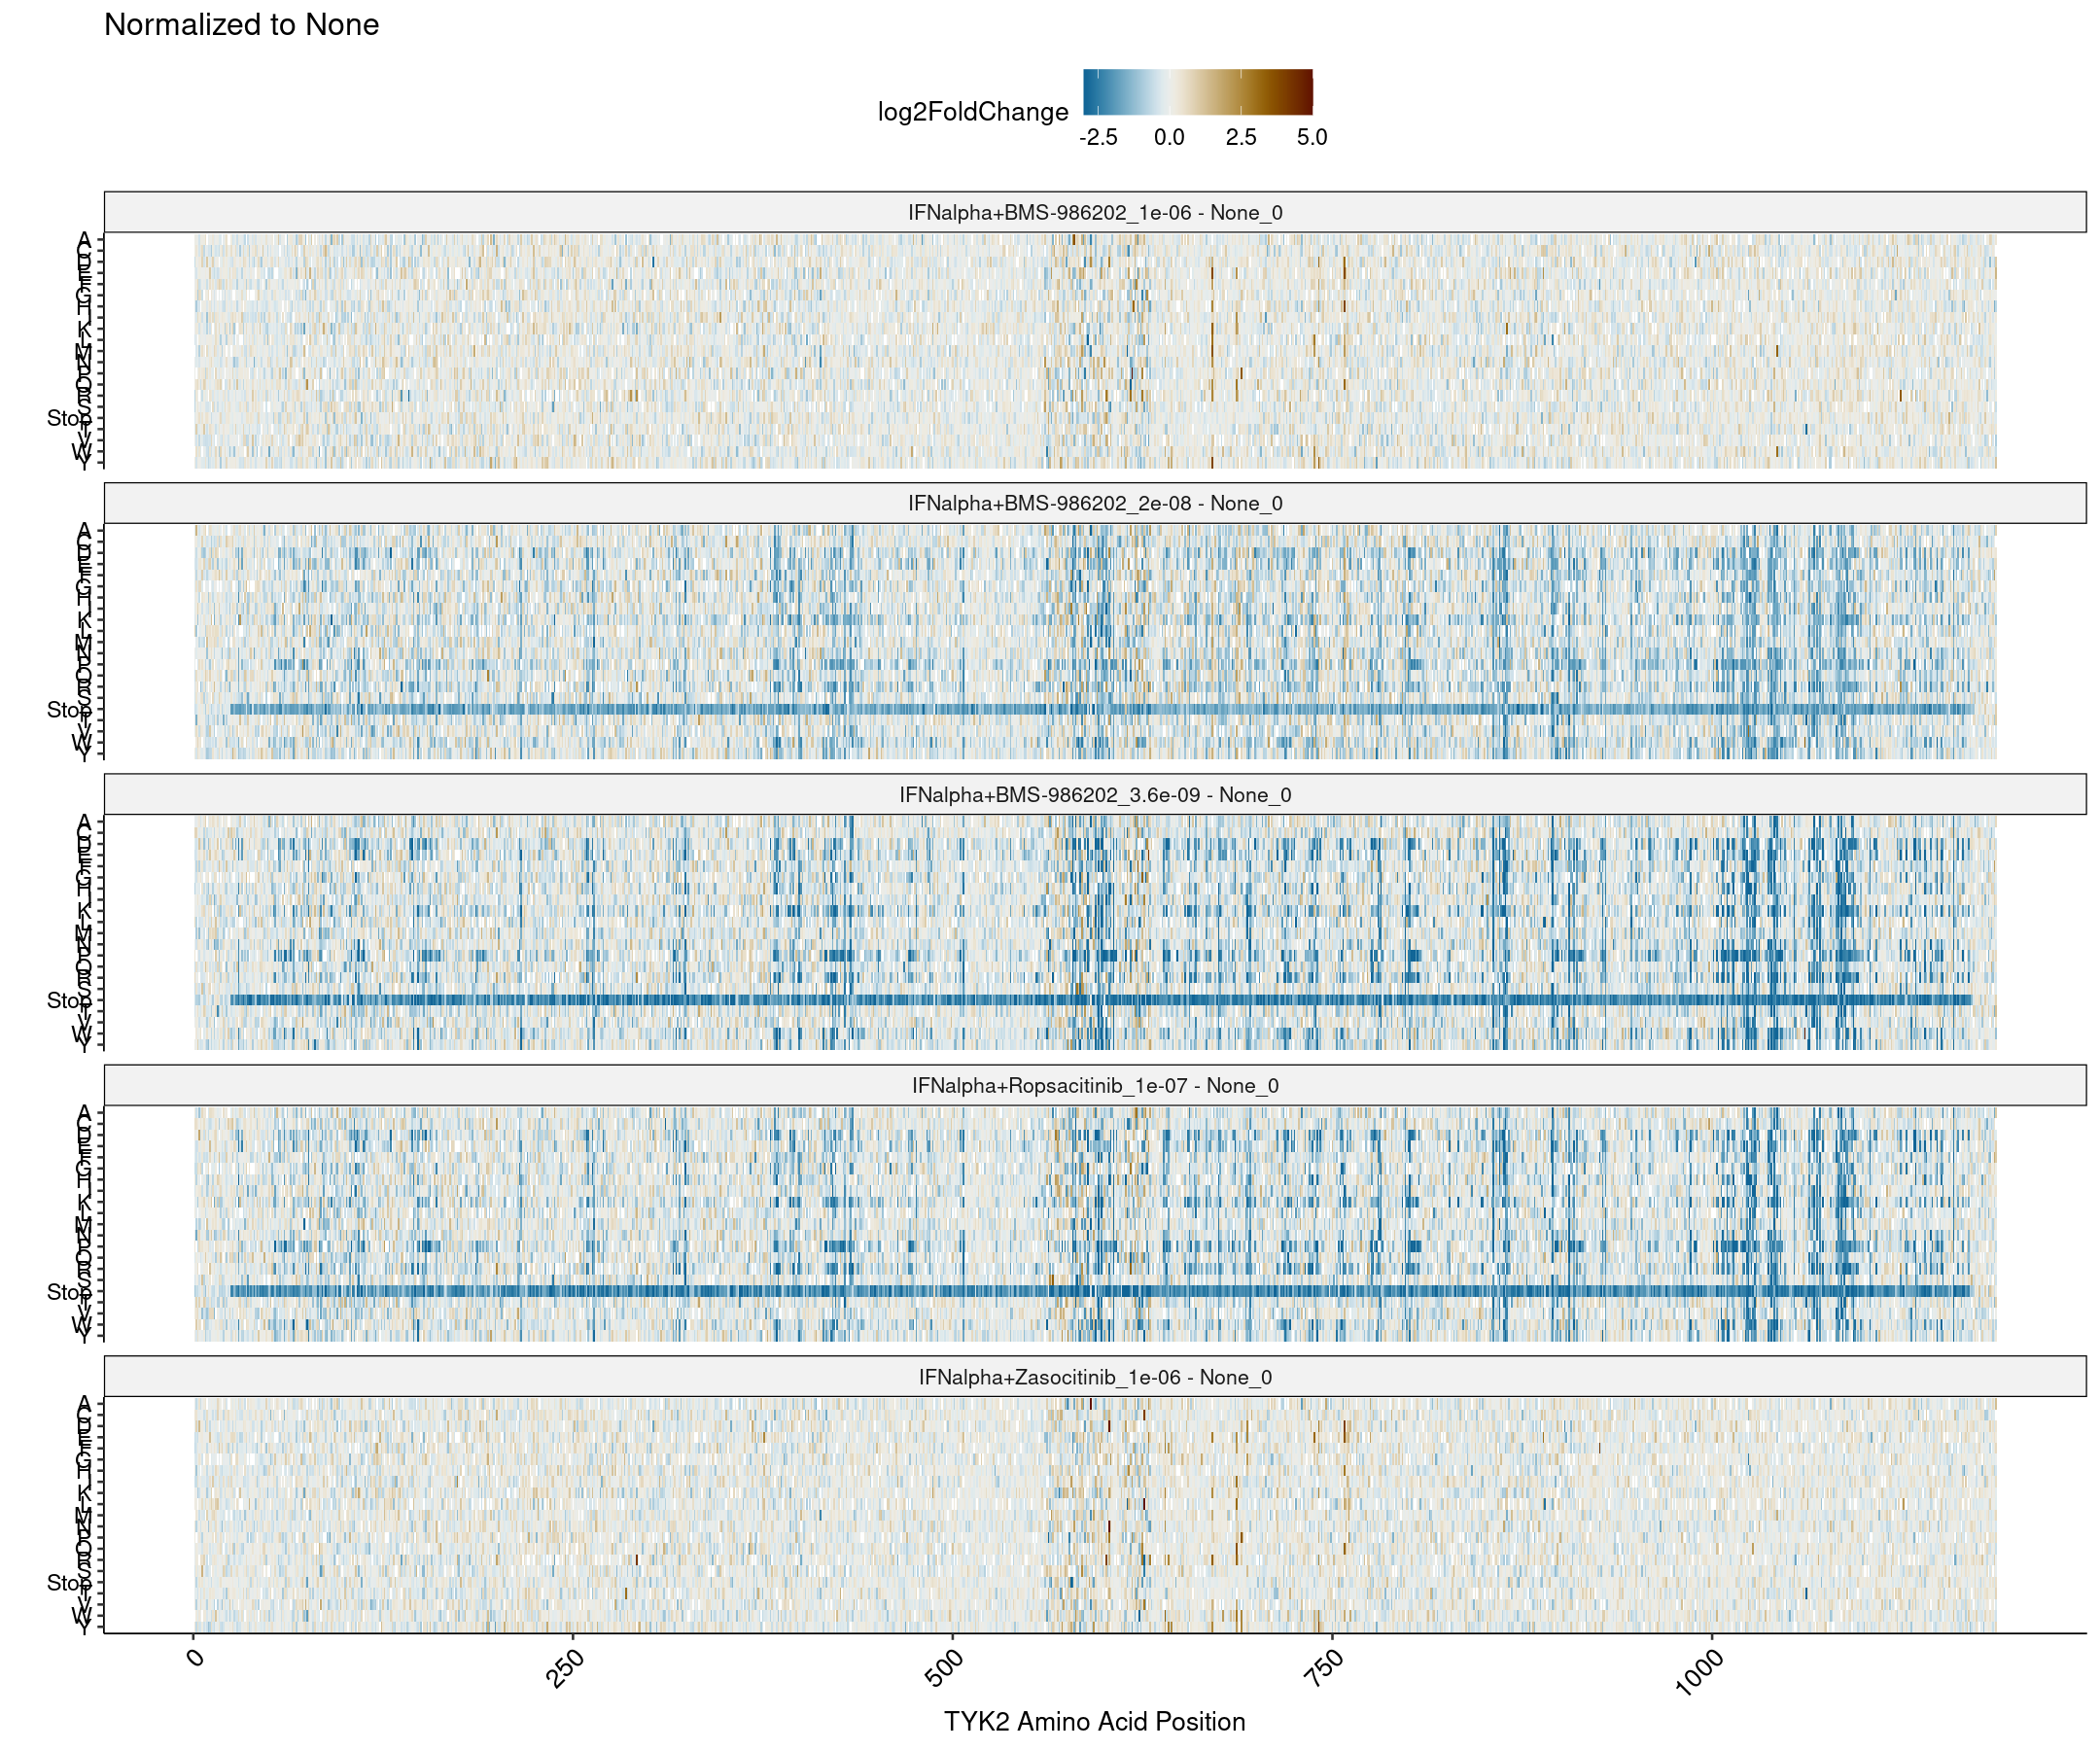

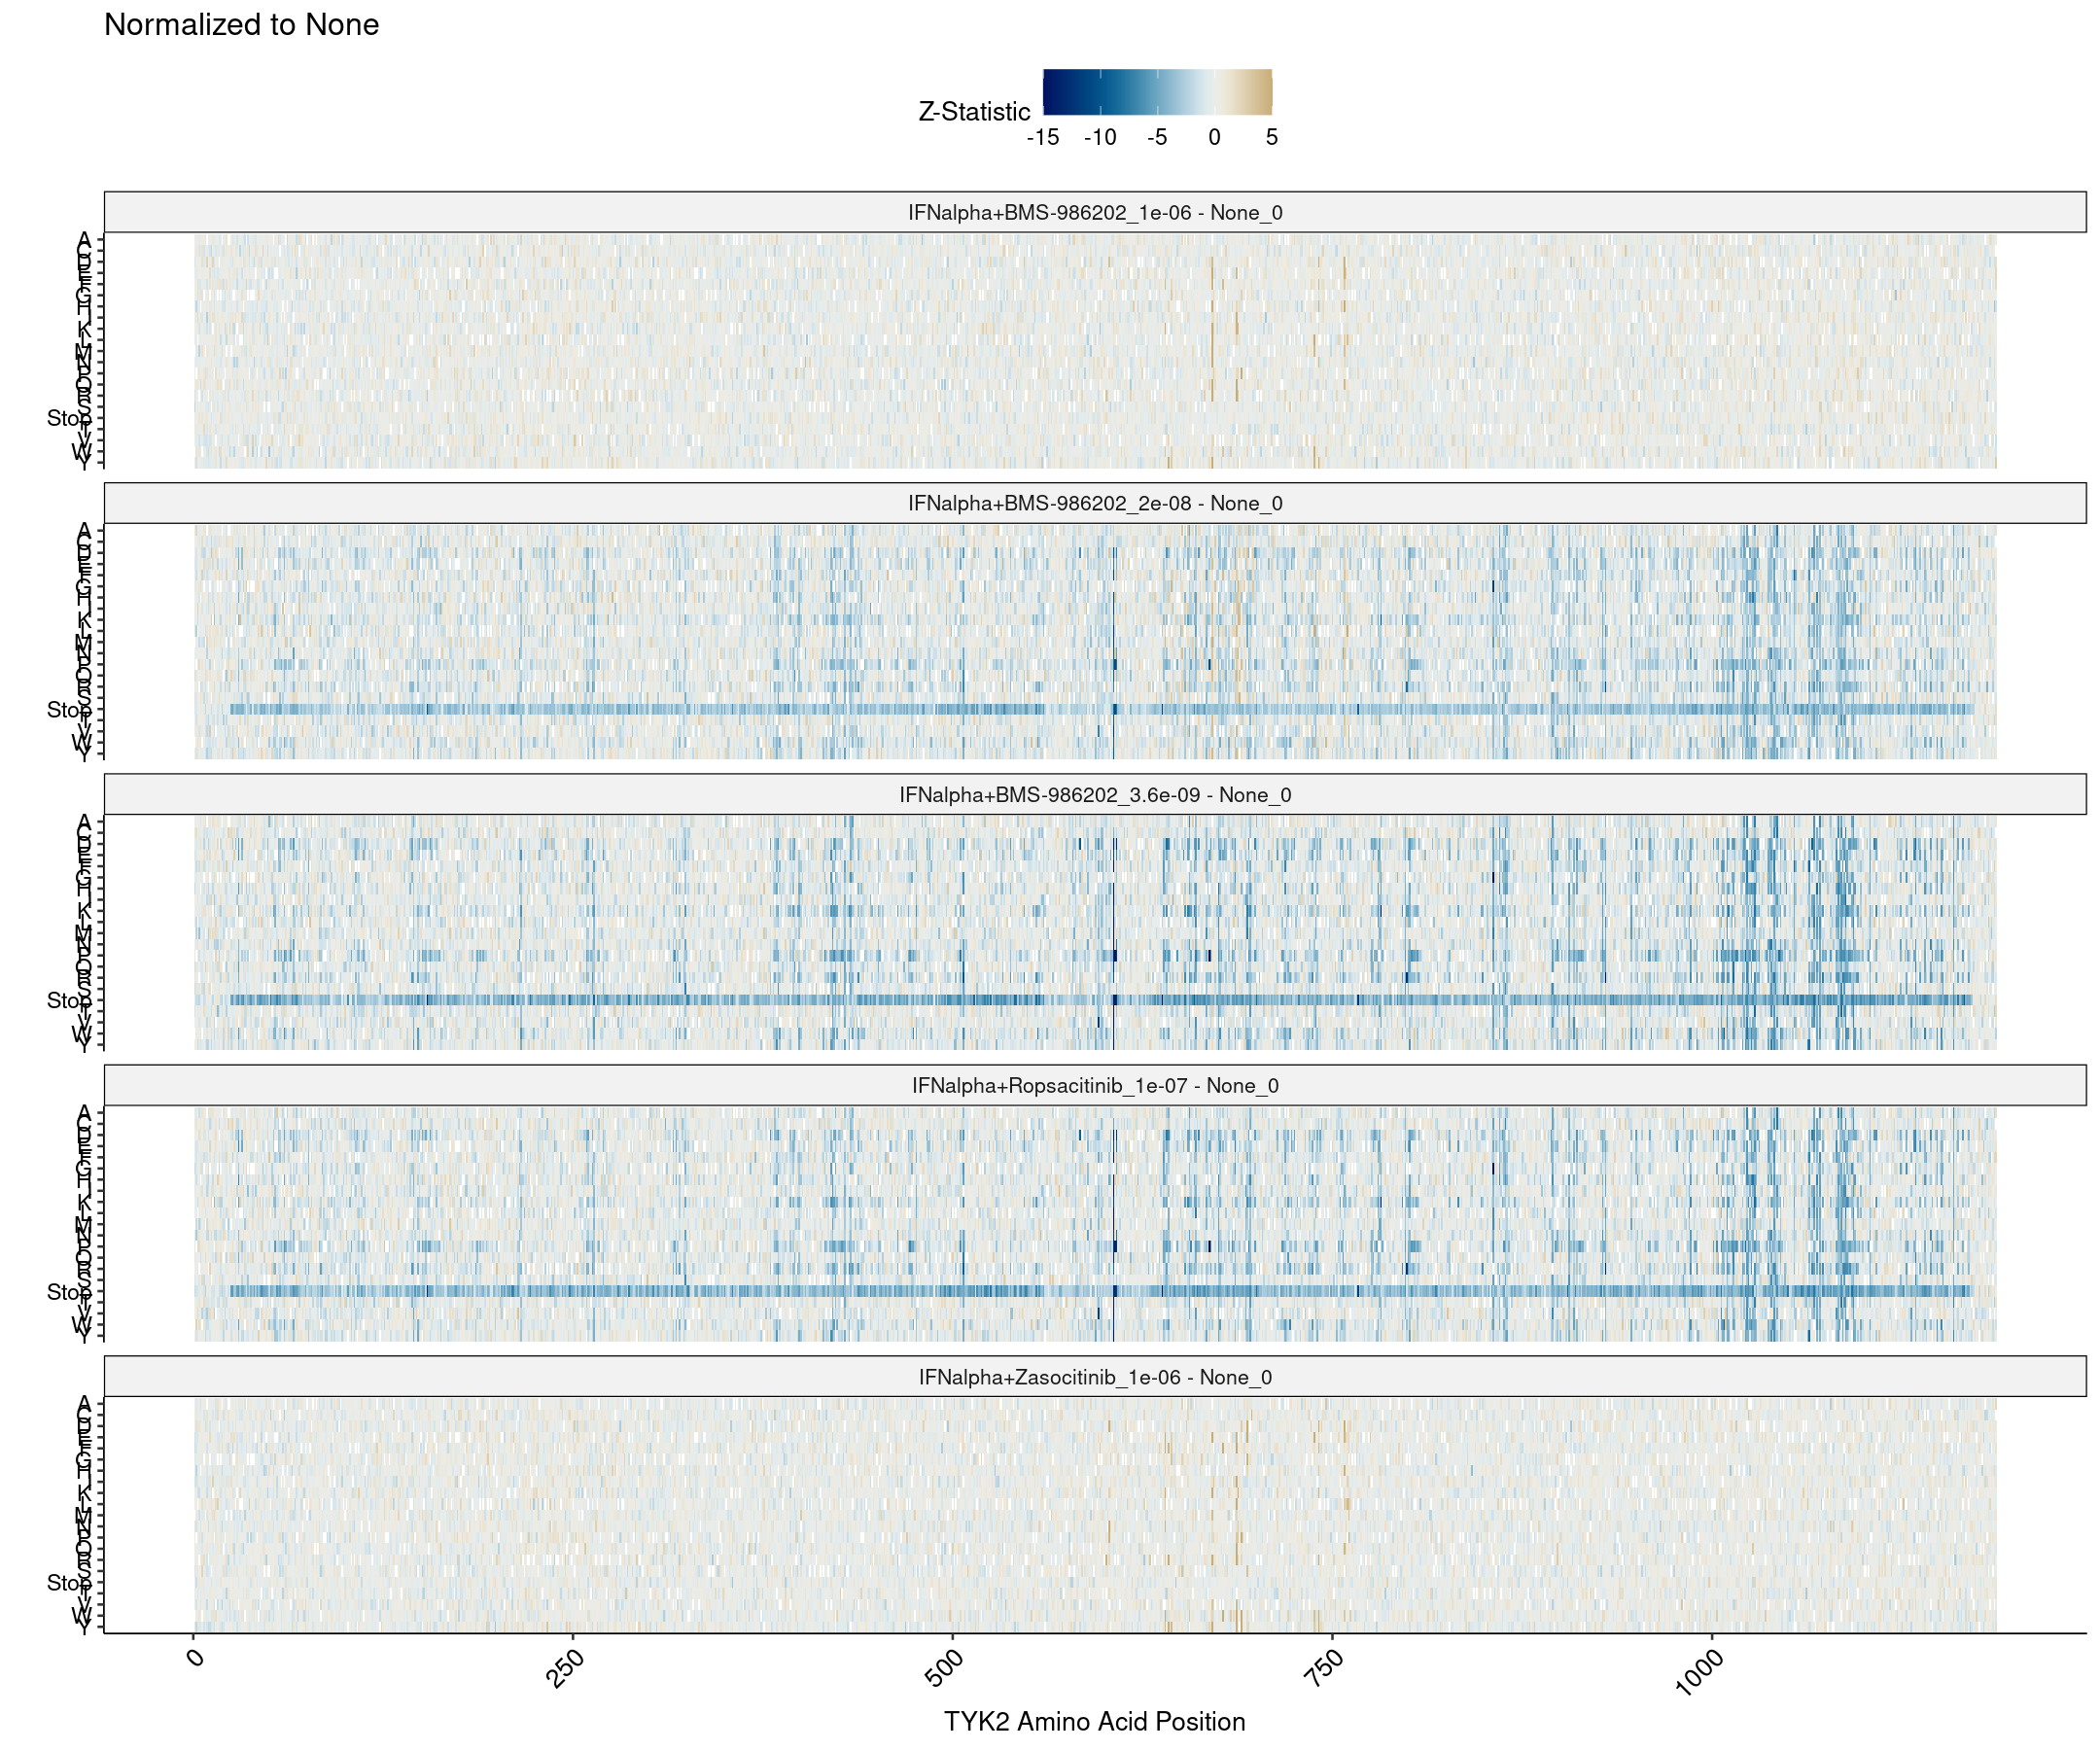

In [9]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa),
           log2FoldChange = estimate/log(2)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa),
           log2FoldChange = estimate/log(2)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

### Drug Resistance/Gain-of-Function <a name="part4"></a>

These are the GoF variants in each of the Normalized comparisons only (though we can also consider other variant sets). First, the BMS-986202 variant sets:

In [4]:
sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha+BMS-986202", conc == 3.6e-09) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")

sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha+BMS-986202", conc == 2e-08) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")

sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha+BMS-986202", conc == 1e-06) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")



|condition                            | pos|aa |  estimate| std.error|     p.adj|
|:------------------------------------|---:|:--|---------:|---------:|---------:|
|IFNalpha+BMS-986202_3.6e-09 - None_0 | 158|V  | 1.5435087| 0.3849236| 0.0015981|
|IFNalpha+BMS-986202_3.6e-09 - None_0 | 521|A  | 0.9101119| 0.2561762| 0.0075101|
|IFNalpha+BMS-986202_3.6e-09 - None_0 | 995|V  | 1.0676228| 0.3015366| 0.0078077|



|condition                          |  pos|aa |  estimate| std.error|     p.adj|
|:----------------------------------|----:|:--|---------:|---------:|---------:|
|IFNalpha+BMS-986202_2e-08 - None_0 |   31|K  | 1.4719264| 0.4064396| 0.0060369|
|IFNalpha+BMS-986202_2e-08 - None_0 |  276|H  | 1.2868636| 0.3128541| 0.0011024|
|IFNalpha+BMS-986202_2e-08 - None_0 |  457|F  | 0.9343545| 0.2687803| 0.0095985|
|IFNalpha+BMS-986202_2e-08 - None_0 |  552|W  | 0.8733678| 0.2417263| 0.0062042|
|IFNalpha+BMS-986202_2e-08 - None_0 |  640|M  | 1.0340211| 0.2462368| 0.0008025|
|IFNalpha+BMS-986202_2e-08 - None_0 |  644|G  | 1.1970502| 0.2734211| 0.0004111|
|IFNalpha+BMS-986202_2e-08 - None_0 |  651|N  | 0.7574797| 0.2083275| 0.0057675|
|IFNalpha+BMS-986202_2e-08 - None_0 |  655|A  | 1.0891106| 0.3120483| 0.0092017|
|IFNalpha+BMS-986202_2e-08 - None_0 |  671|E  | 1.1836206| 0.3147834| 0.0038120|
|IFNalpha+BMS-986202_2e-08 - None_0 |  671|I  | 1.1225865| 0.2756395| 0.0012761|
|IFNalpha+BMS-986202_2e-08



|condition                          | pos|aa |  estimate| std.error|     p.adj|
|:----------------------------------|---:|:--|---------:|---------:|---------:|
|IFNalpha+BMS-986202_1e-06 - None_0 | 601|R  | 1.9695944| 0.5652972| 0.0093766|
|IFNalpha+BMS-986202_1e-06 - None_0 | 603|D  | 1.8976524| 0.5135711| 0.0047353|
|IFNalpha+BMS-986202_1e-06 - None_0 | 640|F  | 1.0781606| 0.2735480| 0.0020390|
|IFNalpha+BMS-986202_1e-06 - None_0 | 640|K  | 1.3697988| 0.2787993| 0.0000469|
|IFNalpha+BMS-986202_1e-06 - None_0 | 642|Y  | 1.1225038| 0.2311401| 0.0000594|
|IFNalpha+BMS-986202_1e-06 - None_0 | 671|D  | 1.0767988| 0.2712658| 0.0018471|
|IFNalpha+BMS-986202_1e-06 - None_0 | 671|E  | 2.6588986| 0.3063301| 0.0000000|
|IFNalpha+BMS-986202_1e-06 - None_0 | 671|F  | 1.3846201| 0.3023599| 0.0001864|
|IFNalpha+BMS-986202_1e-06 - None_0 | 671|H  | 1.7950875| 0.3049085| 0.0000005|
|IFNalpha+BMS-986202_1e-06 - None_0 | 671|K  | 2.3364120| 0.3420936| 0.0000000|
|IFNalpha+BMS-986202_1e-06 - None_0 | 

Then, the other two inhibitors:

In [11]:
sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha+Zasocitinib") %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")

sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, drug == "IFNalpha+Ropsacitinib") %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")



|condition                           |  pos|aa |  estimate| std.error|     p.adj|
|:-----------------------------------|----:|:--|---------:|---------:|---------:|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  601|R  | 2.7380610| 0.5775535| 0.0000965|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  603|D  | 3.3430349| 0.5095479| 0.0000000|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  603|N  | 4.0882163| 0.8247328| 0.0000388|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  603|P  | 1.9681280| 0.4490537| 0.0004033|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|E  | 1.5194152| 0.2892755| 0.0000105|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|F  | 1.8824709| 0.2745678| 0.0000000|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|K  | 1.8789438| 0.2796418| 0.0000000|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|L  | 0.9693747| 0.2791423| 0.0096971|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|N  | 1.6397340| 0.3656999| 0.0002734|
|IFNalpha+Zasocitinib_1e-06 - None_0 |  640|W  | 2.2785162| 0.3479387| 0.0000000|
|IFNalpha+Zaso



|condition                            | pos|aa | estimate| std.error|     p.adj|
|:------------------------------------|---:|:--|--------:|---------:|---------:|
|IFNalpha+Ropsacitinib_1e-07 - None_0 | 570|I  |  1.47329| 0.3712224| 0.0018527|

Notably, Ropsacitinib has far fewer GoF variants than the other two inhibitors (at least at the higest BMS-986202 concentration). We can relax the FDR filter to 5% and see which variants are returned:

In [12]:
sumstats_all %>%
    filter(p.adj < 0.05, estimate > 0, drug == "IFNalpha+Ropsacitinib") %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")



|condition                            |  pos|aa |  estimate| std.error|     p.adj|
|:------------------------------------|----:|:--|---------:|---------:|---------:|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |   50|F  | 1.0541922| 0.3324601| 0.0241452|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  126|P  | 1.4344593| 0.4181414| 0.0110738|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  169|M  | 0.9489253| 0.3067219| 0.0298489|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  200|C  | 1.4602570| 0.4825970| 0.0360600|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  200|R  | 1.7514247| 0.5417656| 0.0202056|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  214|V  | 1.2470533| 0.3723937| 0.0142652|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  299|S  | 1.0758430| 0.3166588| 0.0122974|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  518|E  | 0.8205508| 0.2701840| 0.0350047|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  552|W  | 0.7438906| 0.2451350| 0.0352205|
|IFNalpha+Ropsacitinib_1e-07 - None_0 |  570|I  | 1.4732898| 0.3712224| 0.0018527|
|I

The signal is fairly distributed, with two positions showing multiple effects at 200 and 1009. However, we do see some spatial organization when plotting the counts of the above mutations along the structure:

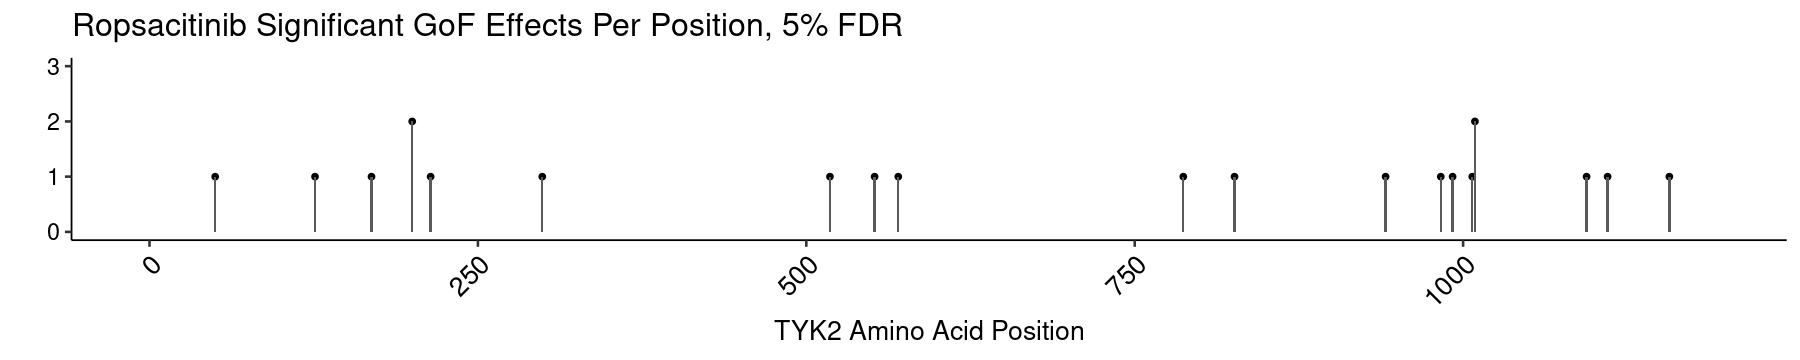

In [13]:
options(repr.plot.height = 3, repr.plot.width = 15)
sumstats_all %>%
    filter(p.adj < 0.05, estimate > 0, drug == "IFNalpha+Ropsacitinib") %>%
    count(pos) %>%
    ggplot() +
        geom_point(aes(x = pos, y = n)) +
        geom_bar(aes(x = pos, y = n), stat = "identity") +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        theme(legend.text=element_text(size=14),
              legend.key.size = unit(1,"cm"),
              axis.text.y = element_text(size = 14)) +
        ylab("") + xlab("TYK2 Amino Acid Position") +
        ylim(c(0,3)) + xlim(c(0,1187)) +
        ggtitle("Ropsacitinib Significant GoF Effects Per Position, 5% FDR")

It is likely that a higher concentration of Ropsacitinib would reasonably generate a more distinctive drug resistance profile, based on these results and the comparison to different concentrations of BMS-986202.

In [67]:
make_profile <- function(poss, df){
    
    p1 <- df %>%
        filter(pos == poss) %>%
        ggplot() +
            geom_pointrange(aes(x = aa, y = estimate, color = condition,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error),
                            position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16) +
            geom_hline(yintercept = 0) + ggtitle(poss) +
            scale_color_manual(values = c("red", "black")) +
            theme(legend.text = element_text(size = 16)) +
            xlab("Amino Acid") + ylab("Log2FoldChange +/- 2 Standard Errors") +
            ggtitle(str_c("Position ", poss))

    return(p1)
}

p671 <- make_profile(671, sumstats_all %>% filter(grepl("1e-06", condition)))
p687 <- make_profile(687, sumstats_all %>% filter(grepl("1e-06", condition)))

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay4-Pos671.pdf",
       p671,
       width = 15,
       height = 5)

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay4-Pos687.pdf",
       p687,
       width = 15,
       height = 5)

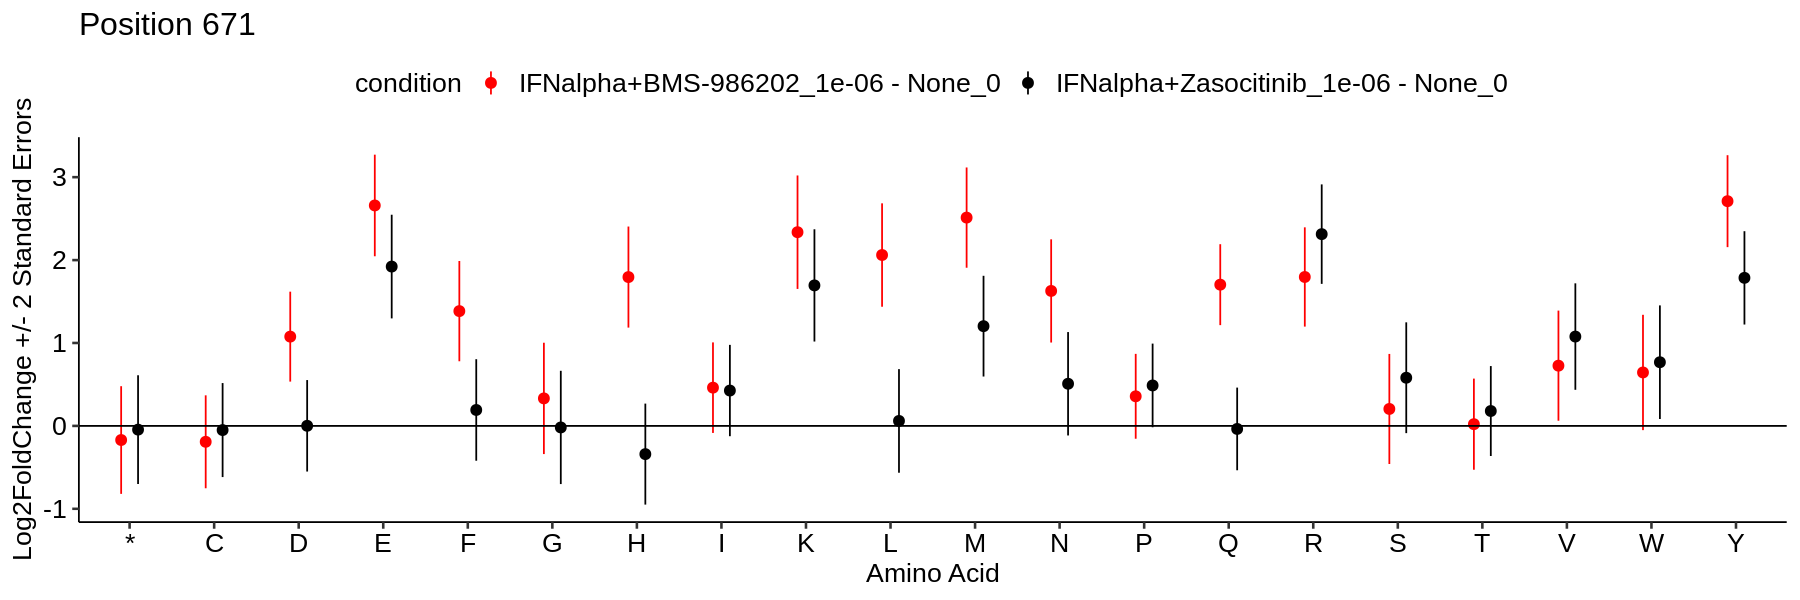

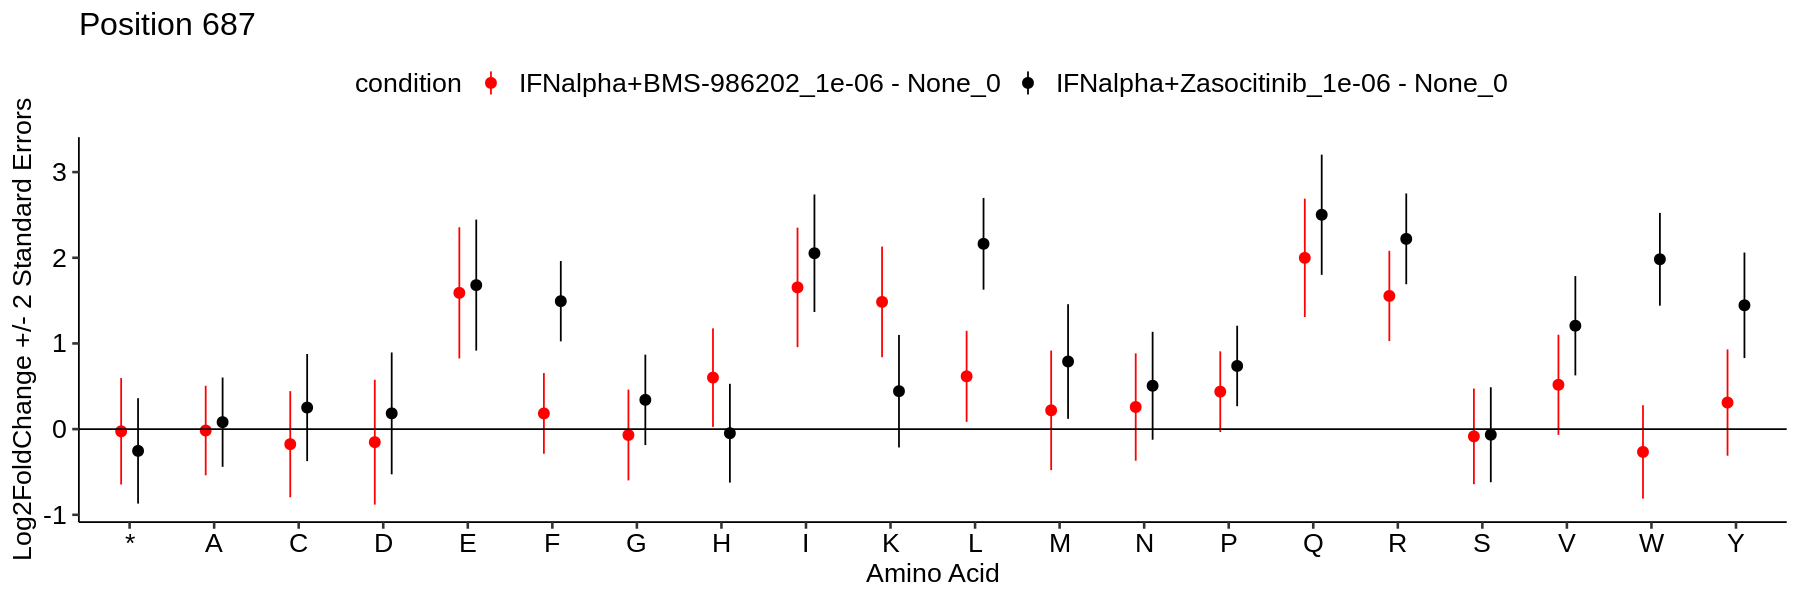

In [126]:
options(repr.plot.width = 15, repr.plot.height = 5)
p671
p687